In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [2]:
HOME_DIR='~/aiffel/ocr/data'
SAMPLE_IMG_PATH = os.path.join(os.getenv('HOME'),'aiffel/ocr/data/sample.jpg')
print(SAMPLE_IMG_PATH)

/aiffel/aiffel/ocr/data/sample.jpg


In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS2 = ENG_CHAR_UPPER + NUMBERS
print(f"The total number oaf characters is {len(TARGET_CHARACTERS2)}")

The total number oaf characters is 36


In [5]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


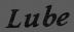

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


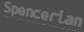

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


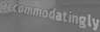

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


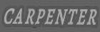

In [41]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [39]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         previous_char = None
         for char in text:
             if char in self.label_map:  # 문자 집합에 포함된 경우 처리
                # 이전 문자와 동일한 경우 공백("-") 추가
                if previous_char == char:
                    encoded_label.append(self.label_map["-"])
                encoded_label.append(self.label_map[char])
                previous_char = char
             else:
                raise ValueError(f"Character '{char}' is not in the target character set.")
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [7]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [8]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [26]:
import keras_ocr

In [27]:
from keras_ocr.detection import Detector
HOME_DIR='~/aiffel/ocr/data'
SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [33]:
#pipeline=keras_ocr.pipline.pipeline()
pipeline = keras_ocr.pipeline.Pipeline()


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [34]:
import matplotlib.pyplot as plt


# Get a set of three example images
images = [
    keras_ocr.tools.read(url) for url in [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/b/b4/EUBanana-500x112.jpg'
    ]
]

In [35]:
import time

# Measure inference time
start_time = time.time()
kerasocr_preds = pipeline.recognize(images)
end_time = time.time()

# Calculate and display inference time
inference_time = end_time - start_time
print(f"Inference Time: {inference_time:.2f} seconds")

Inference Time: 12.20 seconds


keras_ocr을 이용한 글자 탐지


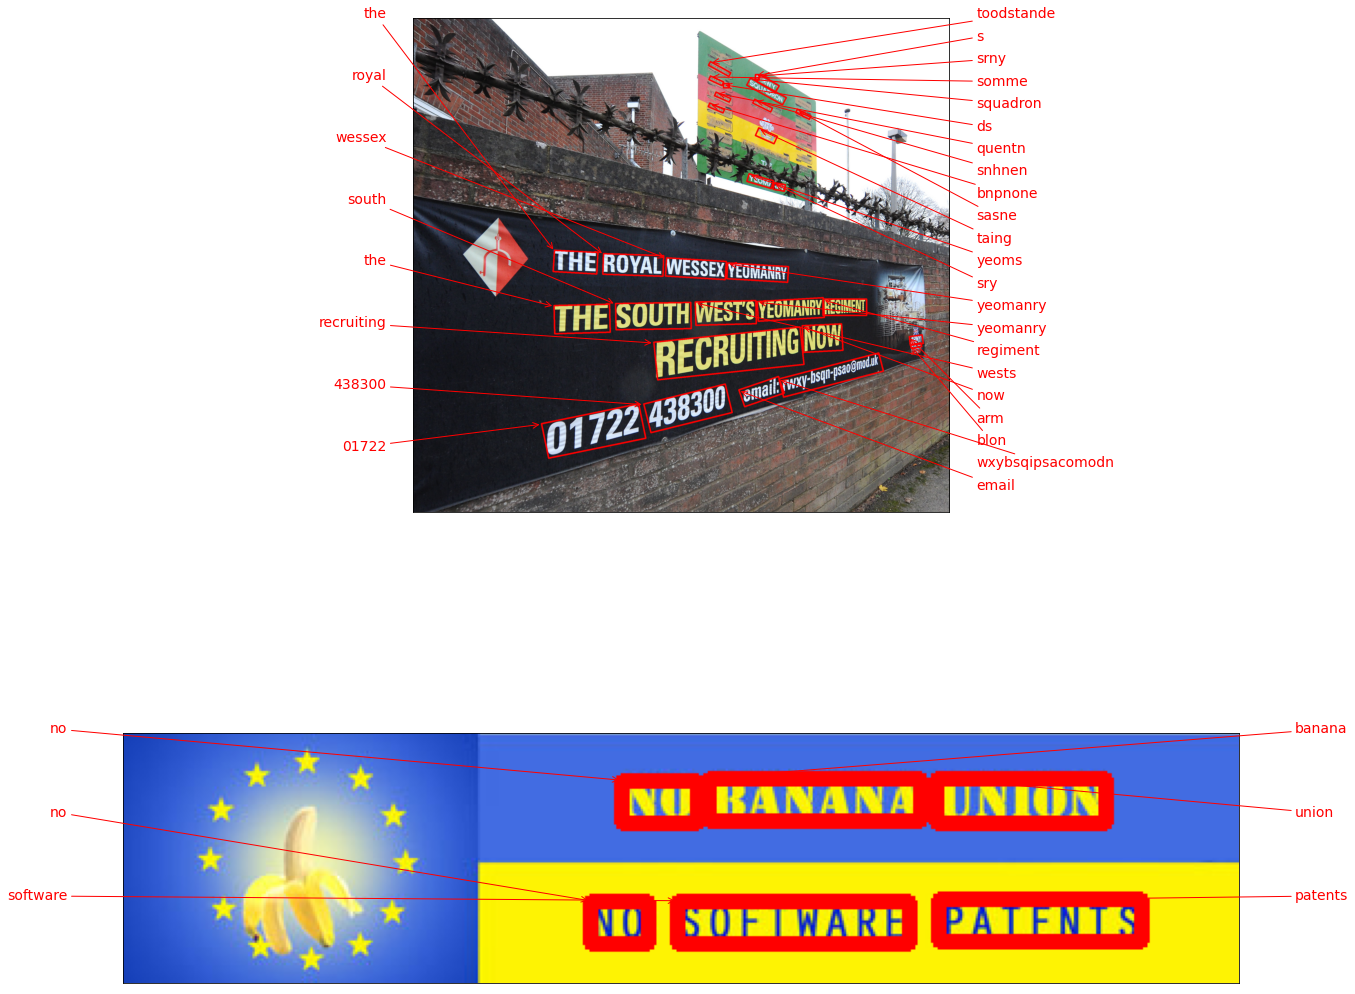

In [37]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, kerasocr_preds):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

Detected Text:
Word: yielyig, Box: [[281.8156  450.021  ]
 [715.5324  402.75705]
 [730.53217 540.4028 ]
 [296.8154  587.66675]]
Word: sleper, Box: [[269.26883 643.607  ]
 [689.8353  613.4468 ]
 [700.2845  759.1539 ]
 [279.718   789.314  ]]


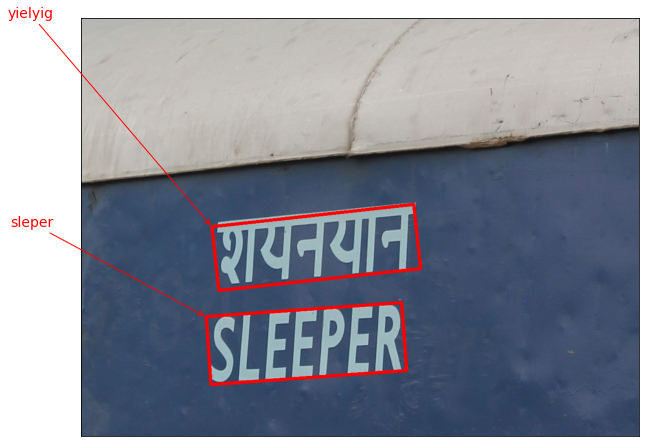

In [63]:
# Load the sample image
image = keras_ocr.tools.read(SAMPLE_IMG_PATH)

# Perform OCR on the image
predictions = pipeline.recognize([image])

# Print the recognized text
print("Detected Text:")
for word, box in predictions[0]:
    print(f"Word: {word}, Box: {box}")

# Plot the image with annotations
fig, ax = plt.subplots(figsize=(10, 10))
keras_ocr.tools.drawAnnotations(image=image, predictions=predictions[0], ax=ax)
plt.show()

IMDB 데이터 탐지해보기

In [53]:
# Initialize the OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Open LMDB environment
env = lmdb.open(TRAIN_DATA_PATH, readonly=True, lock=False)

# Access the data and process images
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # Generate keys
        label_key = f'label-{index:09d}'.encode()
        img_key = f'image-{index:09d}'.encode()
        
        # Read label and image
        label = txn.get(label_key).decode('utf-8')
        imgbuf = txn.get(img_key)

        # Convert buffer to file-like object for keras_ocr.tools.read
        buf = six.BytesIO(imgbuf)
        img = keras_ocr.tools.read(buf)  # Returns a NumPy array

        # OCR Inference
        prediction_groups = pipeline.recognize([img])

        # Display the image and OCR results
        display(Image.fromarray(img))
        print(f"Label: {label}")
        print("OCR Result:")
        for word, box in prediction_groups[0]:
            print(f"Word: {word}, Box: {box}")


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


Label: Lube
OCR Result:
Word: lube, Box: [[ 3.821302   7.9088736]
 [68.34201    3.4591742]
 [70.01065   27.654438 ]
 [ 5.4899445 32.104137 ]]


Label: Spencerian
OCR Result:
Word: spencerian, Box: [[ 3.0381584  -0.5022335 ]
 [83.69508    14.716057  ]
 [80.13716    33.57305   ]
 [-0.51976395 18.354763  ]]


Label: accommodatingly
OCR Result:
Word: samodatingly, Box: [[ 14.899242     0.34760666]
 [116.154655    16.45642   ]
 [113.66145     32.127956  ]
 [ 12.406044    16.019142  ]]


Label: CARPENTER
OCR Result:
Word: carpenter, Box: [[  4.071213    6.735993 ]
 [138.11716     8.050169 ]
 [137.92445    27.705143 ]
 [  3.8785095  26.390966 ]]


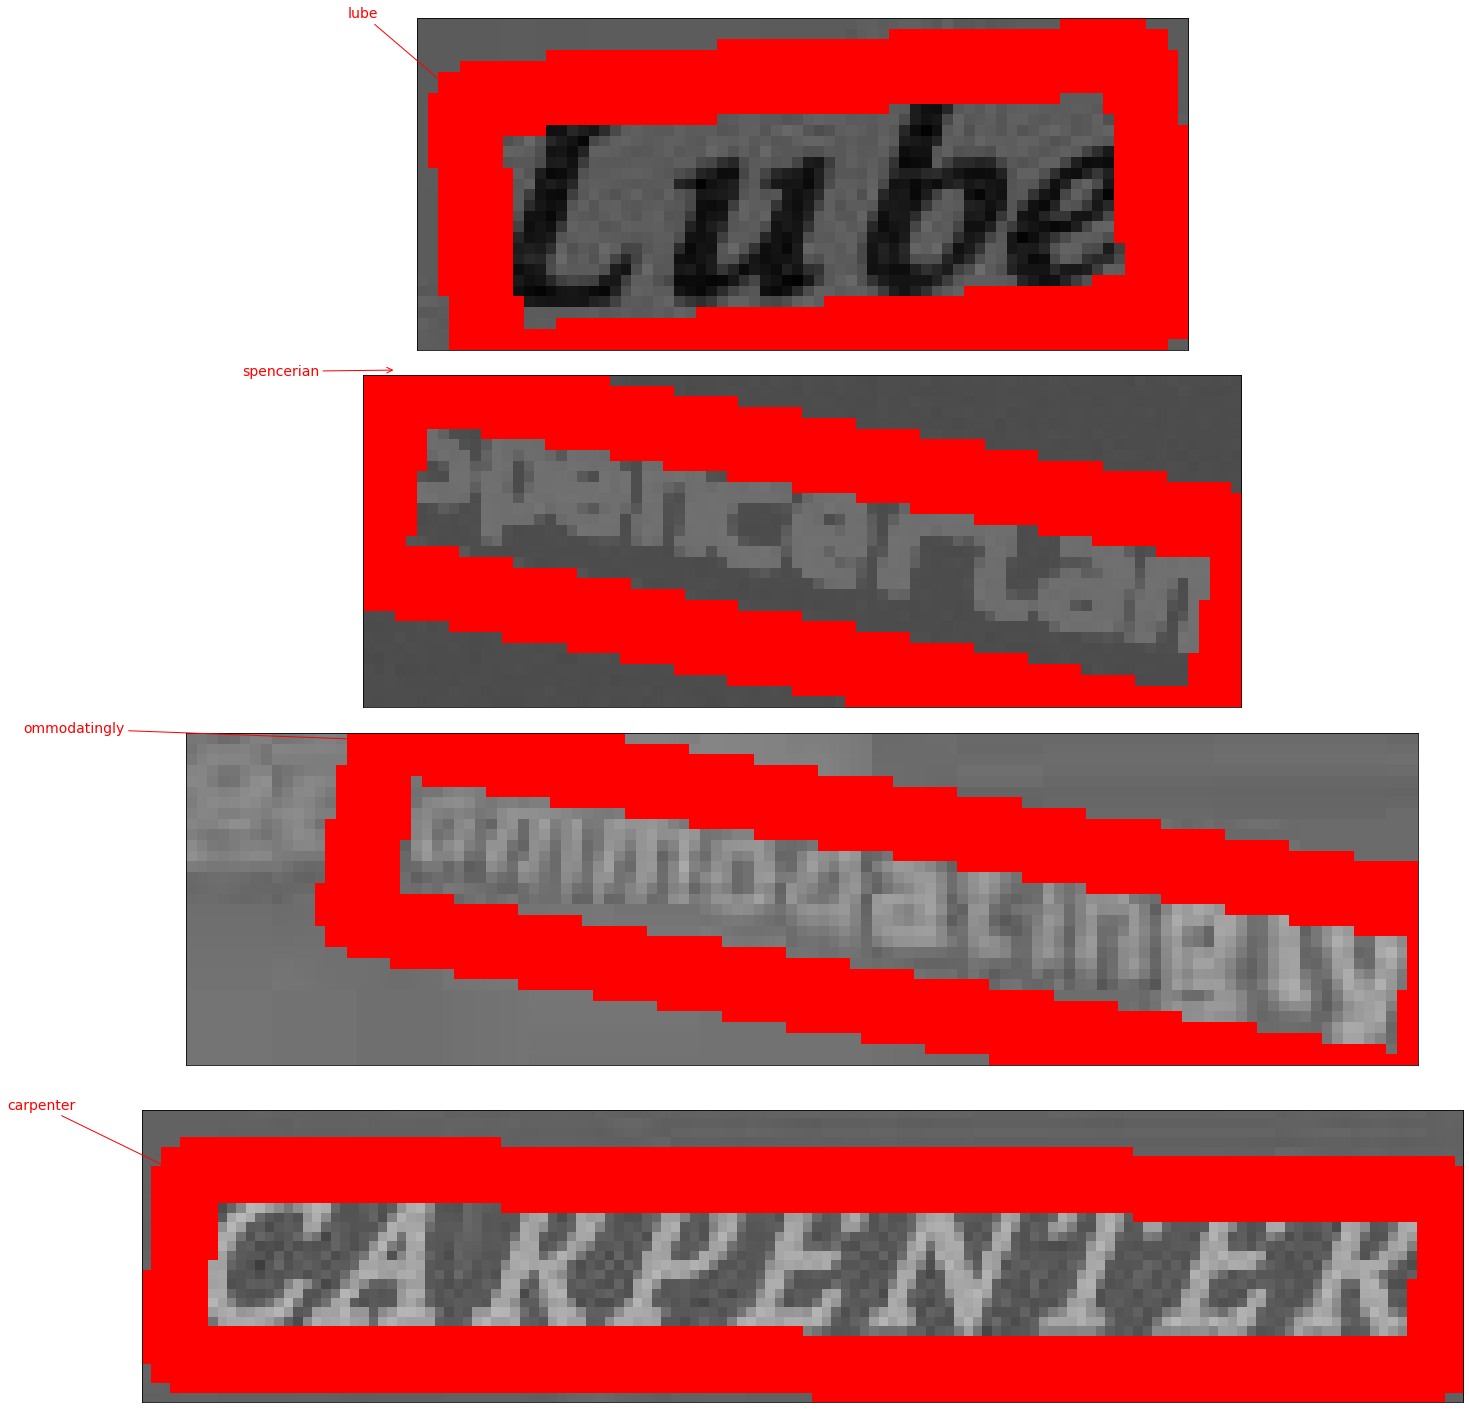

In [54]:

# Open LMDB environment
env = lmdb.open(TRAIN_DATA_PATH, readonly=True, lock=False)

# List to store images and predictions
images = []
kerasocr_preds = []

# Access the data and process images
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # Generate keys
        label_key = f'label-{index:09d}'.encode()
        img_key = f'image-{index:09d}'.encode()
        
        # Read label and image
        label = txn.get(label_key).decode('utf-8')
        imgbuf = txn.get(img_key)

        # Convert buffer to file-like object for keras_ocr.tools.read
        buf = six.BytesIO(imgbuf)
        img = keras_ocr.tools.read(buf)  # Returns a NumPy array

        # Append images for plotting
        images.append(img)

# Perform OCR on all images
kerasocr_preds = pipeline.recognize(images)

# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))

# Handle single or multiple images dynamically
if len(images) == 1:
    axs = [axs]  # Wrap single ax in a list

for ax, image, predictions in zip(axs, images, kerasocr_preds):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)

plt.tight_layout()
plt.show()

탐지 정확도 확인

Average Text Similarity: 0.63


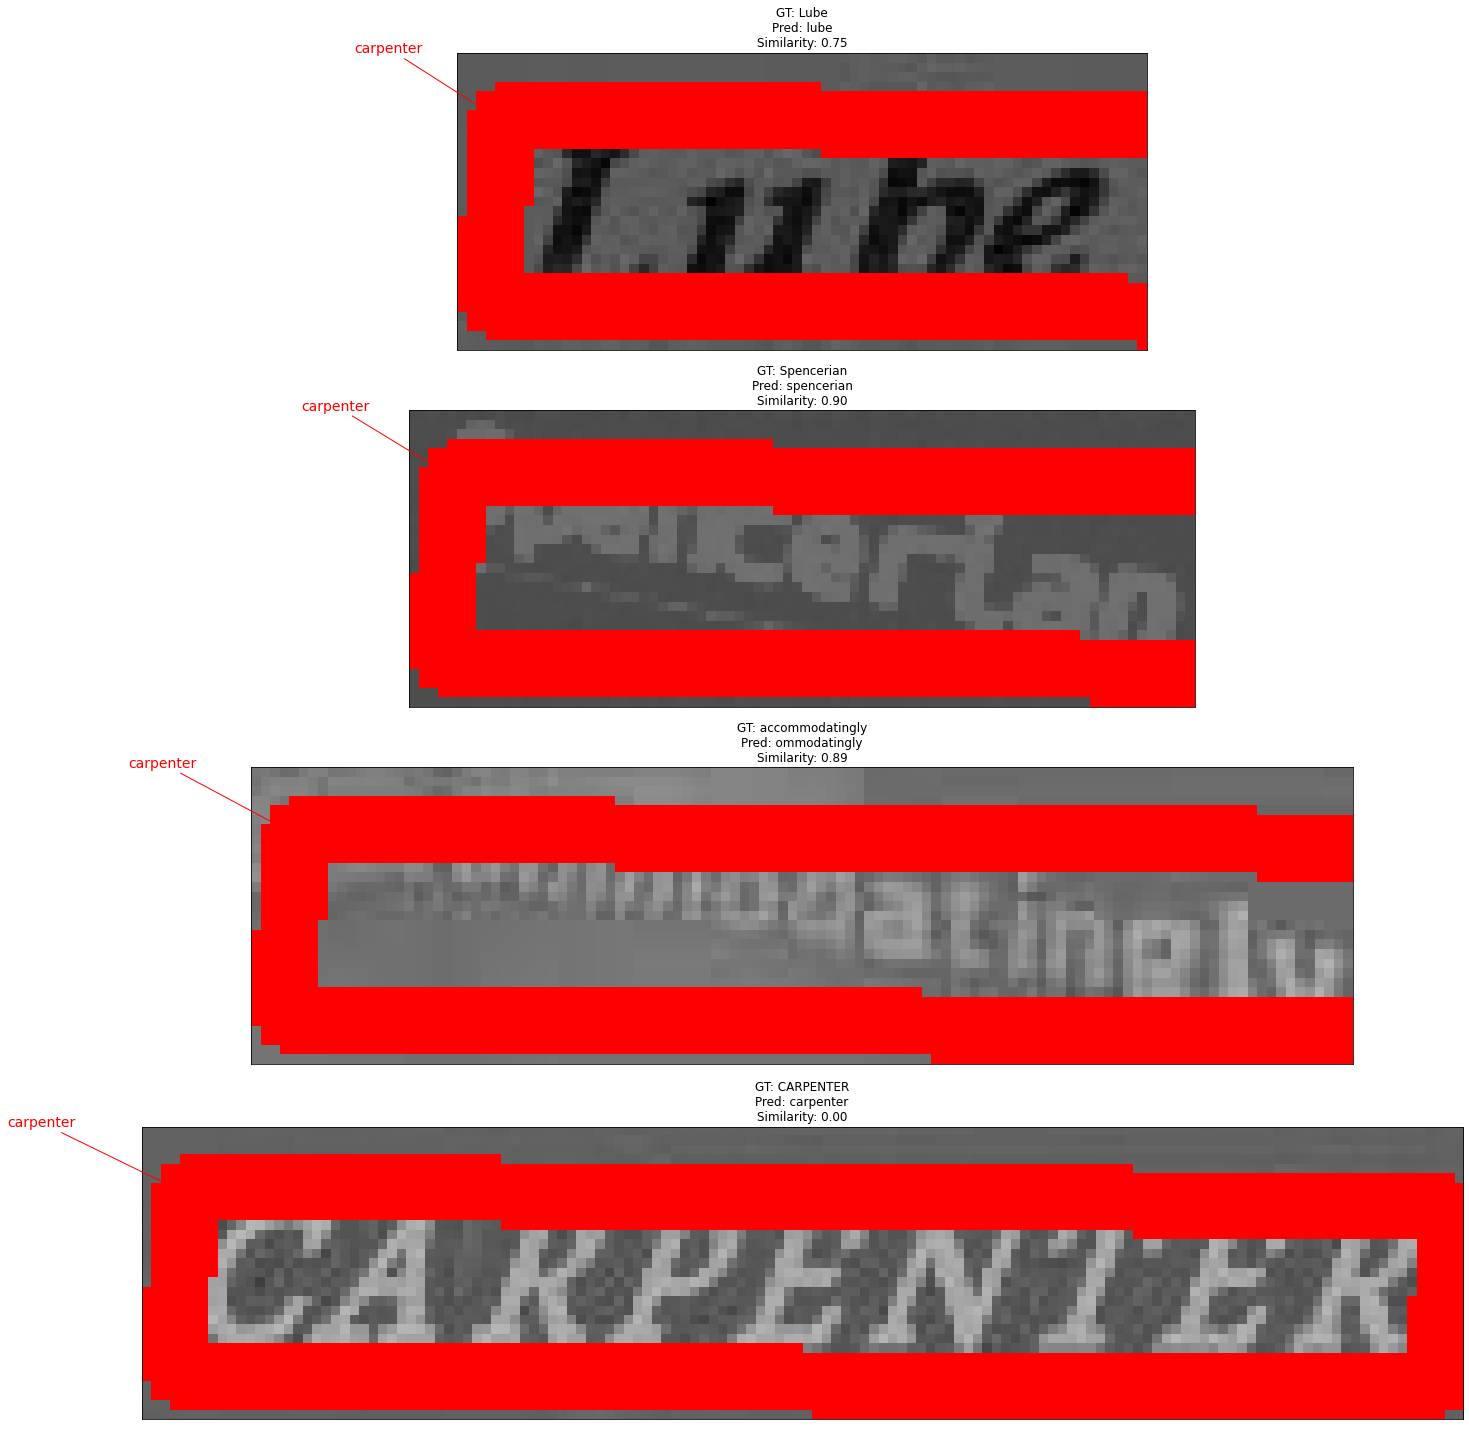

In [56]:
from difflib import SequenceMatcher  # For text similarity


# Lists to store images, ground truth labels, and predictions
images = []
labels = []

# Access the data and process images
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # Generate keys
        label_key = f'label-{index:09d}'.encode()
        img_key = f'image-{index:09d}'.encode()
        
        # Read label and image
        label = txn.get(label_key).decode('utf-8')
        imgbuf = txn.get(img_key)

        # Convert buffer to file-like object for keras_ocr.tools.read
        buf = six.BytesIO(imgbuf)
        img = keras_ocr.tools.read(buf)  # Returns a NumPy array

        # Append image and label
        images.append(img)
        labels.append(label)

# Perform OCR on all images
kerasocr_preds = pipeline.recognize(images)

# Evaluate performance
total_similarity = 0
results = []

for label, predictions in zip(labels, kerasocr_preds):
    # Combine recognized words into a single string
    predicted_text = " ".join([word for word, box in predictions])
    
    # Compute similarity between ground truth and predicted text
    similarity = SequenceMatcher(None, label, predicted_text).ratio()
    total_similarity += similarity
    
    # Store results for visualization
    results.append((label, predicted_text, similarity))

# Calculate average similarity
average_similarity = total_similarity / len(labels)
print(f"Average Text Similarity: {average_similarity:.2f}")

# Plot results
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))

if len(images) == 1:
    axs = [axs]  # Ensure axs is iterable for a single image

for ax, image, (label, predicted_text, similarity) in zip(axs, images, results):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)
    ax.set_title(f"GT: {label}\nPred: {predicted_text}\nSimilarity: {similarity:.2f}")

plt.tight_layout()
plt.show()

In [102]:
import keras_ocr
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# Keras OCR Detector 초기화
detector = keras_ocr.detection.Detector()


# Keras OCR Pipeline 초기화
pipeline = keras_ocr.pipeline.Pipeline()


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [140]:
# 텍스트 영역 탐지 및 잘라내기 함수
# 잘린 이미지에서는 바운딩 박스 표시 하지 않도로 코드 변경
def detect_text(img_path):
    """
    Keras OCR Detector를 사용하여 이미지에서 텍스트 영역을 탐지하고,
    원본 이미지는 수정하지 않은 상태로 반환하며, 탐지된 텍스트 영역 이미지를 잘라 반환합니다.

    Args:
        img_path (str): 입력 이미지 파일 경로.

    Returns:
        img_pil (PIL.Image): 빨간 박스가 없는 원본 이미지.
        cropped_imgs (list): 탐지된 텍스트 영역의 잘라낸 이미지 리스트.
    """
    # 입력 이미지를 로드하고 RGB 형식으로 변환
    img_pil = Image.open(img_path).convert("RGB")
    img_np = np.array(img_pil)  # NumPy 배열로 변환

    # 텍스트 영역 탐지
    ocr_result = detector.detect([img_np])[0]

    # 원본 이미지를 수정하지 않기 위해 복사본 생성
    img_with_annotations = img_pil.copy()
    img_draw = ImageDraw.Draw(img_with_annotations)

    cropped_imgs = []  # 잘라낸 텍스트 영역 이미지를 저장할 리스트
    for text_result in ocr_result:
        # 탐지된 텍스트 영역을 복사본 이미지에 빨간 박스로 표시
        img_draw.polygon([tuple(point) for point in text_result], outline="red")

        # 탐지된 텍스트 영역의 경계 좌표 계산
        x_min = text_result[:, 0].min() - 5
        x_max = text_result[:, 0].max() + 5
        y_min = text_result[:, 1].min() - 5
        y_max = text_result[:, 1].max() + 5
        word_box = [x_min, y_min, x_max, y_max]

        # 원본 이미지에서 텍스트 영역을 잘라내기
        cropped_imgs.append(img_pil.crop(word_box))

    return img_with_annotations, cropped_imgs

# def detect_text(img_path):
#     """
#     Keras OCR의 Detector를 이용하여 이미지 내 텍스트 영역을 탐지하고,
#     탐지된 텍스트 영역을 시각화하며 잘라낸 이미지를 반환합니다.

#     Args:
#         img_path (str): 입력 이미지 파일 경로.

#     Returns:
#         img_pil (PIL.Image): 텍스트 영역이 시각화된 이미지.
#         cropped_imgs (list): 잘려진 텍스트 영역 이미지 리스트.
#     """
#     # 이미지 로드 및 배열로 변환
#     img_pil = Image.open(img_path).convert("RGB")
#     img_np = np.array(img_pil)

#     # 텍스트 탐지 (배치 차원 추가 및 입력 차원 맞춤)
#     ocr_result = detector.detect([img_np])[0]

#     # 탐지된 텍스트 영역 시각화 및 잘라내기
#     img_draw = ImageDraw.Draw(img_pil)
#     cropped_imgs = []
#     for text_result in ocr_result:
#         # 텍스트 영역 시각화 (경계 상자 그리기)
#         img_draw.polygon([tuple(point) for point in text_result])

#         # 텍스트 영역 좌표 계산
#         x_min = text_result[:, 0].min() - 5
#         x_max = text_result[:, 0].max() + 5
#         y_min = text_result[:, 1].min() - 5
#         y_max = text_result[:, 1].max() + 5
#         word_box = [x_min, y_min, x_max, y_max]

#         # 텍스트 영역 자르기
#         cropped_imgs.append(img_pil.crop(word_box))

#     return img_pil, cropped_imgs


# 잘려진 이미지에서 텍스트를 인식하는 함수
def recognize_img(img_pil):
    """
    잘려진 이미지를 Keras OCR Pipeline을 사용해 텍스트를 인식하고,
    결과를 시각화합니다. 단, cropped_imgs에는 주석(빨간 박스)을 제거합니다.

    Args:
        pil_img (PIL.Image): 입력 잘려진 이미지.

    Returns:
        predictions (list): 인식된 텍스트와 경계 상자 정보 리스트.
    """
    # PIL 이미지를 NumPy 배열로 변환
    img_np = np.array(img_pil)

    # OCR 수행
    predictions = pipeline.recognize([img_np])[0]

    # 예측 결과를 시각화
    fig, ax = plt.subplots(figsize=(10, 10))
    keras_ocr.tools.drawAnnotations(image=img_np, predictions=predictions, ax=ax)
    plt.tight_layout()
    plt.show()

    # 인식된 텍스트 출력
    for word, box in predictions:
        print(f"Detected Word: {word}")

    return predictions


탐지 및 잘라내기 구현

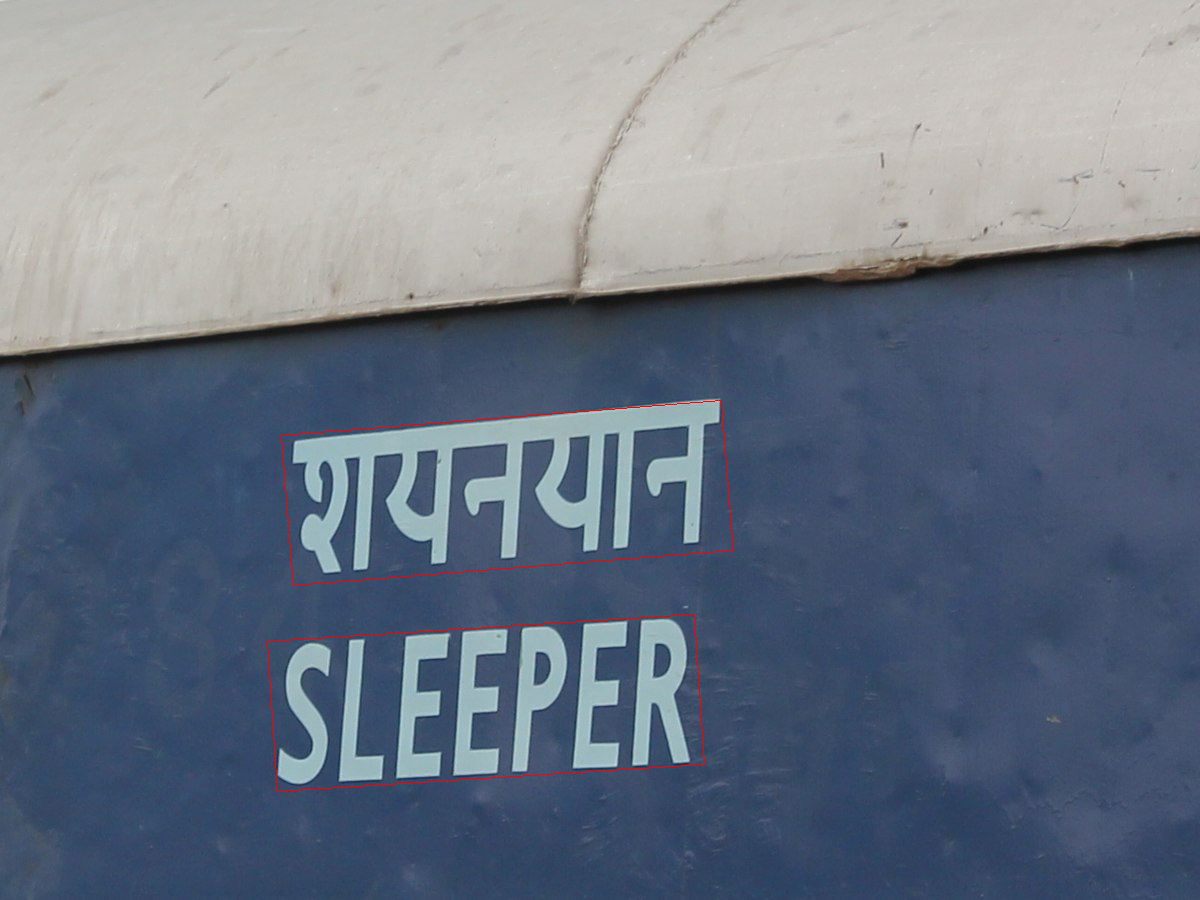

In [144]:
 # 텍스트 탐지 및 잘라내기

img_with_annotations, cropped_imgs = detect_text(SAMPLE_IMG_PATH)

# Show the image 
img_with_annotations.show()


잘린 이미지 1:


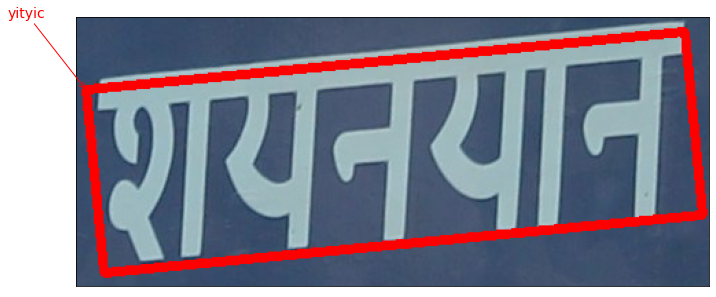

Detected Word: yityic
잘린 이미지 2:


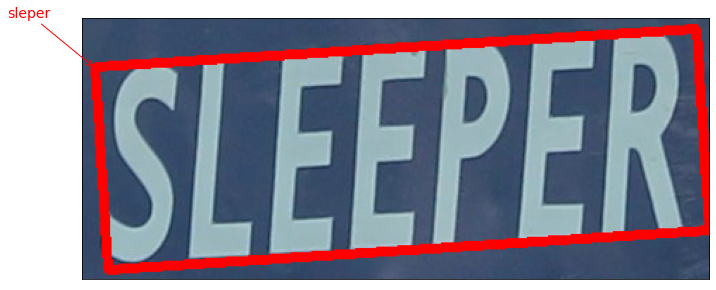

Detected Word: sleper


In [143]:
# 잘라진 이미지에서 텍스트 인식
for idx, cropped_img in enumerate(cropped_imgs):
    print(f"잘린 이미지 {idx + 1}:")
    try:
        # 텍스트 인식 수행
        recognize_img(cropped_img)
    except Exception as e:
        print(f"오류가 발생했습니다: {e}")

In [26]:
# 데이터 경로 설정
import os

HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [27]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model


import keras_ocr
import lmdb
import numpy as np
from PIL import Image
import io
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint



# 데이터 경로 확인
print("학습 데이터 경로:", TRAIN_DATA_PATH)
print("검증 데이터 경로:", VALID_DATA_PATH)
print("테스트 데이터 경로:", TEST_DATA_PATH)

# # LMDB 데이터 로드 함수
# def load_data_from_lmdb(env_path, max_samples=None):
#     """
#     LMDB 데이터셋에서 텍스트와 이미지를 로드합니다.

#     Args:
#         env_path (str): LMDB 데이터셋 경로.
#         max_samples (int): 로드할 최대 샘플 수 (옵션).

#     Returns:
#         images (list): 텍스트 이미지 데이터.
#         labels (list): 텍스트 레이블 데이터.
#     """
#     env = lmdb.open(env_path, readonly=True, lock=False)
#     images, labels = [], []
#     with env.begin(write=False) as txn:
#         cursor = txn.cursor()
#         idx = 0
#         for key, value in cursor:
#             if key.startswith(b"image"):
#                 # 이미지 및 레이블 키
#                 img_key = key
#                 label_key = b"label-" + key.split(b"-")[1]

#                 # 레이블 디코딩
#                 label = txn.get(label_key).decode("utf-8")

#                 # 이미지를 PIL.Image로 로드 및 크기 조정
#                 img_buf = io.BytesIO(value)
#                 img = Image.open(img_buf).convert("RGB")
#                 img = img.resize((100, 32))  # CRNN 입력 크기로 리사이즈

#                 # NumPy 배열로 변환
#                 img_np = np.array(img)

#                 # 데이터 저장
#                 images.append(img_np)
#                 labels.append(label)

#                 idx += 1
#                 if max_samples and idx >= max_samples:
#                     break
#     return images, labels



학습 데이터 경로: /aiffel/aiffel/ocr/data/MJ/MJ_train
검증 데이터 경로: /aiffel/aiffel/ocr/data/MJ/MJ_valid
테스트 데이터 경로: /aiffel/aiffel/ocr/data/MJ/MJ_test


In [28]:
import io
import lmdb
import numpy as np
from PIL import Image

def load_data_from_lmdb(env_path, max_samples=None):
    """
    LMDB 데이터셋에서 텍스트와 이미지를 로드합니다.

    Args:
        env_path (str): LMDB 데이터셋 경로.
        max_samples (int): 로드할 최대 샘플 수 (옵션).

    Returns:
        images (np.ndarray): 텍스트 이미지 데이터 (NumPy 배열).
        labels (list): 텍스트 레이블 데이터.
    """
    # LMDB 환경 초기화
    env = lmdb.open(env_path, readonly=True, lock=False)
    images, labels = [], []
    
    with env.begin(write=False) as txn:
        cursor = txn.cursor()
        idx = 0
        
        for key, value in cursor:
            # 이미지 키 확인
            if key.startswith(b"image"):
                try:
                    # 이미지 및 레이블 키 생성
                    img_key = key
                    label_key = b"label-" + key.split(b"-")[1]
                    
                    # 레이블 로드 및 디코딩
                    label = txn.get(label_key).decode("utf-8")
                    
                    # 이미지 로드 및 전처리
                    img_buf = io.BytesIO(value)
                    img = Image.open(img_buf).convert("RGB")
                    img = img.resize((100, 32))  # CRNN 입력 크기
                    
                    # NumPy 배열 변환
                    img_np = np.array(img)
                    
                    # 데이터 저장
                    images.append(img_np)
                    labels.append(label)
                    
                except Exception as e:
                    print(f"Error loading data for key {key}: {e}")
                    continue
                
                # 최대 샘플 수 체크
                idx += 1
                if max_samples and idx >= max_samples:
                    break

    # NumPy 배열로 변환
    return np.array(images), labels


In [29]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [30]:
# Target characters 정의 (예: 알파벳 + 숫자 + 공백)
# NUMBERS = "0123456789"
# ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
# TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS

TARGET_CHARACTERS = '0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ '

In [31]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         previous_char = None
         for char in text:
             if char in self.label_map:  # 문자 집합에 포함된 경우 처리
                # 이전 문자와 동일한 경우 공백("-") 추가
                if previous_char == char:
                    encoded_label.append(self.label_map["-"])
                encoded_label.append(self.label_map[char])
                previous_char = char
             else:
                raise ValueError(f"Character '{char}' is not in the target character set.")
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [32]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [44 41 48  0 48 51]
Decoded_text:  HEL-LO


In [33]:
import tensorflow.keras.backend as K



# Keras에서 제공하는 K.ctc_batch_cost()를 활용해서 loss를 계산

def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [34]:
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers






# CRNN 모델 정의 함수
def build_crnn_model(input_shape=(100, 32, 3), characters=TARGET_CHARACTERS):
    num_chars = len(characters) + 2  # 추가 문자는 CTC의 블랭크 토큰
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')

    # Conv layers
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)

    # Feature map을 RNN 입력 형식으로 변환
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequence = layers.Reshape(target_shape=(24, 512))(feature)
    sequence = layers.Dense(64, activation='relu')(sequence)
    sequence = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequence)
    sequence = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequence)

    # Softmax 출력
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequence)

    # CTC 손실 함수에 필요한 추가 입력
    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    
    # Lambda 레이어로 CTC 손실 계산    
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )

    # 모델 정의
    model_input = [image_input, labels, input_length, label_length]
    model = Model(inputs=model_input, outputs=loss_out)
    return model

BATCH_SIZE=16
# 모델 생성
model = build_crnn_model()

print("모델 생성 완료!")


모델 생성 완료!


In [35]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

In [36]:
# 저장된 전체 모델 로드
load_path = HOME_DIR + '/model_checkpoint.hdf5'

In [37]:


# 저장된 가중치 로드 (출력 레이어는 건너뜀)
try:
    model.load_weights(load_path, by_name=True, skip_mismatch=True)
    print("출력 레이어를 제외하고 가중치를 성공적으로 로드했습니다.")
except Exception as e:
    print(f"가중치를 로드하지 못했습니다. 이유: {e}")


출력 레이어를 제외하고 가중치를 성공적으로 로드했습니다.


In [38]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.schedules import (
    ExponentialDecay,
    PiecewiseConstantDecay,
    PolynomialDecay,
    CosineDecay,
    CosineDecayRestarts
)



# 저장된 전체 모델 로드
load_path = HOME_DIR + '/model_checkpoint.hdf5'
try:
    model = load_model(load_path, compile=False)
    print(f"모델을 성공적으로 로드했습니다: {load_path}")
except Exception as e:
    print(f"모델을 로드하지 못했습니다. 이유: {e}")
    
'''  
tf.keras.optimizers.schedules 사용
이 모듈은 다양한 학습률 조정 스케줄을 지원합니다. 이를 활용하면 LearningRateScheduler 없이도 간단히 학습률을 조정할 수 있습니다.

1. ExponentialDecay (지수 감소 스케줄)    

'''
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,  # 초기 학습률
    decay_steps=1000,           # 몇 스텝마다 감소할지
    decay_rate=0.9,             # 감소 비율
    staircase=True              # True면 계단형, False면 연속형
)


# 모델을 컴파일 
optimizer = tf.keras.optimizers.Adadelta(learning_rate=lr_schedule, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    

 
# ModelCheckpoint 및 EarlyStopping 설정

checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# ModelCheckpoint: val_loss를 모니터링하며, 최적의 가중치만 저장
ckp = ModelCheckpoint(
    checkpoint_path,  # 저장 경로
    monitor='val_loss',  # 모니터링 지표
    save_best_only=True,  # 최적의 val_loss일 경우만 저장
    save_weights_only=False,  # 모델 가중치만 저장
    verbose=1  # 저장 시 메시지 출력
)

# EarlyStopping: val_loss를 모니터링하며, 개선이 없으면 조기 종료
earlystop = EarlyStopping(
    monitor='val_loss',  # 모니터링 지표
    patience=20,  # 개선이 없을 경우 10 epoch 후 종료
    verbose=1  # 종료 시 메시지 출력
)

# 모델 학습
history = model.fit(
    train_set, validation_data=val_set, epochs=1, callbacks=[ckp, earlystop]
)

모델을 성공적으로 로드했습니다: /aiffel/aiffel/ocr/model_checkpoint.hdf5
4516/4516 [==============================] - 158s 33ms/step - loss: 0.2521 - val_loss: 4.3409

Epoch 00001: val_loss improved from inf to 4.34086, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5


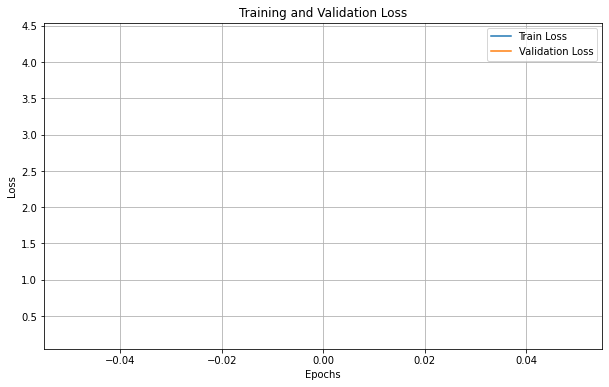

In [40]:

# 추가적으로 필요한 라이브러리 (예: 데이터 처리, 시각화 등)
import numpy as np
import matplotlib.pyplot as plt
# 학습 결과 시각화
def plot_training_history(history):
    """학습 및 검증 손실을 시각화합니다."""
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 시각화 함수 호출
plot_training_history(history)

In [41]:
import json
import numpy as np

def save_history(history, file_path):
    """
    학습 기록(history)을 JSON 파일로 저장.
    float32 값을 Python float으로 변환하여 JSON 직렬화 가능하게 처리.
    """
    history_dict = {
        key: [float(value) if isinstance(value, np.float32) else value for value in values]
        for key, values in history.history.items()
    }
    
    with open(file_path, 'w') as f:
        json.dump(history_dict, f)
    
    print(f"History 저장 완료: {file_path}")

# History 저장
history_file_path = HOME_DIR + '/history.json'
save_history(history, history_file_path)


History 저장 완료: /aiffel/aiffel/ocr/history.json


In [42]:
# history 로드 함수
def load_history(file_path):
    """저장된 JSON 파일에서 학습 기록 로드"""
    with open(file_path, 'r') as f:
        loaded_history = json.load(f)
    print(f"History 로드 완료: {file_path}")
    return loaded_history

# 저장된 history 로드
loaded_history = load_history(history_file_path)

History 로드 완료: /aiffel/aiffel/ocr/history.json


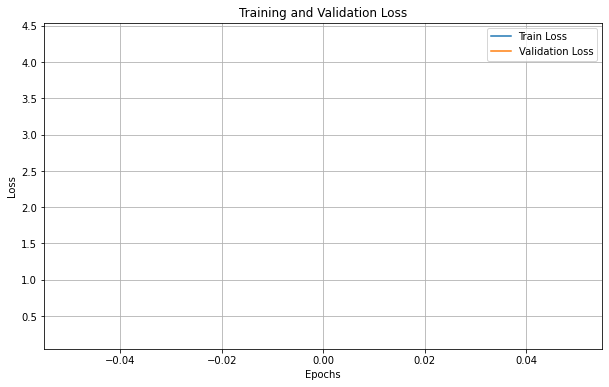

In [43]:
import matplotlib.pyplot as plt

def plot_loaded_history(loaded_history):
    """로드된 학습 기록을 시각화"""
    plt.figure(figsize=(10, 6))
    plt.plot(loaded_history['loss'], label='Train Loss')
    plt.plot(loaded_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 시각화 호출
plot_loaded_history(loaded_history)


In [44]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'


# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path, by_name=True, skip_mismatch=True)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 KEKEKQKQE               


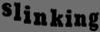

Result: 	 EWEWPWPWPK              


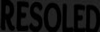

Result: 	 NKNKNKEKNA              


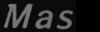

Result: 	 QKQKPKQKQK              


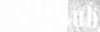

Result: 	 QKPKPKNKN               


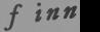

Result: 	 YKEKEKEKEKE             


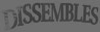

Result: 	 QKEKQKFKF               


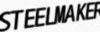

Result: 	 NKQKQKEQWQW             


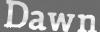

Result: 	 EKEKEKPKF               


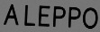

Result: 	 NKNEKPFKF               


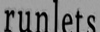

In [45]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [7]:
import keras_ocr

# Keras OCR 파이프라인 초기화
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [8]:
# Recognizer 가중치 저장 (덮어쓰기 허용)
pipeline.recognizer.model.save_weights(checkpoint_path, overwrite=True)
print(f"Recognizer 가중치가 저장되었습니다: {checkpoint_path}")

NameError: name 'checkpoint_path' is not defined

In [ ]:
from tensorflow.keras.models import load_model

# Define a function to load or create a model
def load_or_create_model(checkpoint_path, build_model_func):
    """
    Load an existing model from checkpoint or create a new model if loading fails.

    Args:
        checkpoint_path (str): Path to the model checkpoint file.
        build_model_func (function): Function to build a new model.

    Returns:
        Model: Loaded or newly created model.
    """
    try:
        # Attempt to load the model with specified options
        model = load_model(checkpoint_path, compile=False)
        print(f"Existing model loaded from: {checkpoint_path}")
    except Exception as e:
        print(f"Failed to load existing model. Creating a new model. Reason: {e}")
        model = build_model_func()
    return model

# Use the function to load or create the model
model = load_or_create_model(checkpoint_path, build_crnn_model)

# Compile the model (if needed)
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
print("Model is ready for training or evaluation.")

아이디어1. 디텍터로 자른 이미지로 학습해보자

In [23]:
import os
import numpy as np
from PIL import Image
import keras_ocr
import io
from tensorflow.keras.utils import Sequence

# Keras OCR 파이프라인 초기화
pipeline = keras_ocr.pipeline.Pipeline()

# 텍스트 탐지 및 버퍼 처리 함수
def process_dataset_with_buffer(dataset):
    """데이터셋을 처리하고 텍스트 영역을 버퍼에 저장하여 반환합니다."""
    image_buffers = []  # 버퍼를 저장할 리스트
    labels = []  # 라벨 저장 리스트

    for idx in range(len(dataset.index_list)):
        # 1. 데이터셋에서 이미지와 라벨 가져오기
        img, label = dataset._get_img_label(dataset.index_list[idx])
        
        # 2. NumPy 배열을 PIL 이미지로 변환
        img_pil = Image.fromarray(img.astype('uint8')).convert("RGB")
        
        # 3. Keras OCR 탐지기로 텍스트 영역 탐지
        img_np = np.array(img_pil)
        ocr_result = pipeline.detector.detect([img_np])[0]
        
        # 4. 텍스트 영역 잘라내기 및 버퍼에 저장
        for i, text_result in enumerate(ocr_result):
            x_min = text_result[:, 0].min() - 5
            x_max = text_result[:, 0].max() + 5
            y_min = text_result[:, 1].min() - 5
            y_max = text_result[:, 1].max() + 5
            
            cropped_img = img_pil.crop((x_min, y_min, x_max, y_max))
            
            # 메모리 버퍼에 저장
            buffer = io.BytesIO()
            cropped_img.save(buffer, format='JPEG')
            buffer.seek(0)
            
            image_buffers.append(buffer)
            labels.append(label)  # 해당 라벨 추가
        
        print(f"이미지 {idx} 처리 및 버퍼 저장 완료.")
    
    return image_buffers, labels

# 버퍼에서 이미지 로드
def load_images_from_buffer(image_buffers):
    """버퍼에서 이미지를 로드합니다."""
    loaded_images = []
    for buffer in image_buffers:
        buffer.seek(0)  # 버퍼 포인터를 처음으로 리셋
        loaded_img = Image.open(buffer).resize((100, 32))  # 모델 입력 크기
        img_np = np.array(loaded_img) / 255.0  # 정규화
        loaded_images.append(img_np)
    return np.array(loaded_images)

# 새로운 Sequence 클래스
class OCRSequence(Sequence):
    def __init__(self, images, labels, batch_size):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.images) / self.batch_size))

    def __getitem__(self, idx):
        batch_images = self.images[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array(batch_images), np.array(batch_labels)



Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


용량 문제로 커널 종료현상 발상

In [ ]:
# train_set과 val_set 생성
train_image_buffers, train_labels = process_dataset_with_buffer(train_set)
val_image_buffers, val_labels = process_dataset_with_buffer(val_set)

train_images = load_images_from_buffer(train_image_buffers)
val_images = load_images_from_buffer(val_image_buffers)

BATCH_SIZE = 16
train_sequence = OCRSequence(train_images, train_labels, BATCH_SIZE)
val_sequence = OCRSequence(val_images, val_labels, BATCH_SIZE)

print("train_set과 val_set 준비 완료!")


이미지 0 처리 및 버퍼 저장 완료.
이미지 1 처리 및 버퍼 저장 완료.
이미지 2 처리 및 버퍼 저장 완료.
이미지 3 처리 및 버퍼 저장 완료.
이미지 4 처리 및 버퍼 저장 완료.
이미지 5 처리 및 버퍼 저장 완료.
이미지 6 처리 및 버퍼 저장 완료.
이미지 7 처리 및 버퍼 저장 완료.
이미지 8 처리 및 버퍼 저장 완료.
이미지 9 처리 및 버퍼 저장 완료.
이미지 10 처리 및 버퍼 저장 완료.
이미지 11 처리 및 버퍼 저장 완료.
이미지 12 처리 및 버퍼 저장 완료.
이미지 13 처리 및 버퍼 저장 완료.
이미지 14 처리 및 버퍼 저장 완료.
이미지 15 처리 및 버퍼 저장 완료.
이미지 16 처리 및 버퍼 저장 완료.
이미지 17 처리 및 버퍼 저장 완료.
이미지 18 처리 및 버퍼 저장 완료.
이미지 19 처리 및 버퍼 저장 완료.
이미지 20 처리 및 버퍼 저장 완료.
이미지 21 처리 및 버퍼 저장 완료.
이미지 22 처리 및 버퍼 저장 완료.
이미지 23 처리 및 버퍼 저장 완료.
이미지 24 처리 및 버퍼 저장 완료.
이미지 25 처리 및 버퍼 저장 완료.
이미지 26 처리 및 버퍼 저장 완료.
이미지 27 처리 및 버퍼 저장 완료.
이미지 28 처리 및 버퍼 저장 완료.
이미지 29 처리 및 버퍼 저장 완료.
이미지 30 처리 및 버퍼 저장 완료.
이미지 31 처리 및 버퍼 저장 완료.
이미지 32 처리 및 버퍼 저장 완료.
이미지 33 처리 및 버퍼 저장 완료.
이미지 34 처리 및 버퍼 저장 완료.
이미지 35 처리 및 버퍼 저장 완료.
이미지 36 처리 및 버퍼 저장 완료.
이미지 37 처리 및 버퍼 저장 완료.
이미지 38 처리 및 버퍼 저장 완료.
이미지 39 처리 및 버퍼 저장 완료.
이미지 40 처리 및 버퍼 저장 완료.
이미지 41 처리 및 버퍼 저장 완료.
이미지 42 처리 및 버퍼 저장 완료.
이미지 43 처리 및 버퍼 저장 완료.
이미지 44 처리 및 버퍼 저장 완료.
이미지 45 처리 및 버퍼 저장 완료

In [104]:
len(train_set)

4516

In [106]:
# 첫 번째 배치 데이터 가져오기
inputs, outputs = train_set[0]

# inputs 출력
print("Inputs:")
print(f"input_image: {inputs['input_image'].shape}")  # (2, 32, 100, 3)
print(f"label: {inputs['label'].shape}")  # (2, 22)
print(f"input_length: {inputs['input_length'].shape}")  # (2,)
print(f"label_length: {inputs['label_length'].shape}")  # (2,)

# outputs 출력
print("Outputs:")
print(f"ctc: {outputs['ctc'].shape}")  # (2, 1)


Inputs:
input_image: (16, 100, 32, 3)
label: (16, 22)
input_length: (16,)
label_length: (16,)
Outputs:
ctc: (16, 1)


In [22]:
import os
import lmdb
import six
import numpy as np
from PIL import Image
import re
import math
from tensorflow.keras.utils import Sequence
import keras_ocr
import tensorflow as tf

# Keras OCR 파이프라인 초기화
pipeline = keras_ocr.pipeline.Pipeline()

BATCH_SIZE=16

class MJDatasetSequence(Sequence):
    def __init__(self, dataset_path, label_converter,
                 batch_size=1, img_size=(100,32), max_text_len=22,
                 is_train=False, character=''):
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)

    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')
            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'

            width, height = img.size
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)

            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)

    def __getitem__(self, idx):
        # 이 메서드는 원래 배치 생성 시 호출되나,
        # 우리는 사전 전처리 단계에서 OCR를 모두 처리할 것이므로
        # 여기서는 사용하지 않을 예정.
        pass

# ===========================
# 개선된 로직
# 1. MJDatasetSequence를 활용해 모든 원본 이미지를 로드
# 2. OCR로 텍스트 영역 크롭 한 번에 수행
# 3. 크롭된 이미지를 메모리에 적재 후 tf.data 파이프라인 구성
# ===========================

# 준비된 label_converter 및 파라미터 사용 가정
# TRAIN_DATA_PATH, VALID_DATA_PATH, label_converter, TARGET_CHARACTERS, BATCH_SIZE 등 정의 필요
train_sequence = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_sequence = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)



Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
  # OCR 전처리 함수


    
def preprocess_with_ocr(sequence):
    images_cropped = []
    labels = []

    # sequence.index_list를 이용해 모든 이미지를 처리
    with sequence.env.begin(write=False) as txn:
        for idx in sequence.index_list:
            # 원본 이미지와 라벨 로딩 (MJDatasetSequence 방식)
            label_key = 'label-%09d'.encode() % idx
            lbl = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % idx
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img_pil = Image.open(buf).convert('RGB')
            except IOError:
                img_pil = Image.new('RGB', sequence.img_size)
                lbl = '-'

            # OCR 탐지
            img_np = np.array(img_pil)
            ocr_result = pipeline.detector.detect([img_np])[0]
            if len(ocr_result) == 0:
                # 텍스트 영역 없으면 스킵 또는 기본 처리
                continue

            # 첫 번째 영역만 크롭 가정
            text_poly = ocr_result[0]
            x_min = max(int(text_poly[:,0].min()) - 5, 0)
            x_max = int(text_poly[:,0].max()) + 5
            y_min = max(int(text_poly[:,1].min()) - 5, 0)
            y_max = int(text_poly[:,1].max()) + 5

            cropped_img = img_pil.crop((x_min, y_min, x_max, y_max))
            # 크기 조정 후 정규화
            cropped_img = cropped_img.resize((100, 32))
            cropped_img = np.array(cropped_img) / 255.0

            # 라벨 처리 (MJDatasetSequence와 동일한 규칙)
            #lbl = lbl.upper()
            out_of_char = f'[^{TARGET_CHARACTERS}]'
            lbl = re.sub(out_of_char, '', lbl)
            lbl = lbl[:sequence.max_text_len]

            images_cropped.append(cropped_img)
            labels.append(lbl)

    return np.array(images_cropped), labels



버퍼에 저장은 어려워, 폴더에 저장하기로 함

In [36]:
import os
from PIL import Image
import numpy as np

# Save directory 설정
SAVE_DIR = os.path.join(HOME_DIR, 'ocr/data1/MJ/MJ_test')

# 디렉토리 생성
os.makedirs(SAVE_DIR, exist_ok=True)

# 처리할 이미지 개수와 배치 크기
NUM_IMAGES = 1000
BATCH_SIZE = 500

# 첫 1000개 인덱스 가져오기
first_1000_indices = train_sequence.index_list[:NUM_IMAGES]

# 인덱스를 500개씩 나누기
index_chunks = [first_1000_indices[i:i + BATCH_SIZE] for i in range(0, len(first_1000_indices), BATCH_SIZE)]

# 처리된 이미지 개수 카운터
image_count = 0

# 각 청크를 처리
for chunk in index_chunks:
    print(f"Processing chunk: {chunk[0]} to {chunk[-1]}")
    
    # 청크에 해당하는 데이터셋 생성
    temp_sequence = MJDatasetSequence(
        dataset_path=train_sequence.env.path(),
        label_converter=train_sequence.label_converter,
        batch_size=len(chunk),
        img_size=train_sequence.img_size,
        max_text_len=train_sequence.max_text_len,
        is_train=train_sequence.is_train,
        character=train_sequence.character
    )
    temp_sequence.index_list = chunk  # 현재 청크 인덱스를 할당

    # OCR 전처리 실행
    images_cropped, labels = preprocess_with_ocr(temp_sequence)

    # 이미지를 저장
    for img, label in zip(images_cropped, labels):
        # 이미지를 PIL 형식으로 변환
        img_pil = Image.fromarray((img * 255).astype('uint8'))
        
        # 저장 경로 설정
        save_path = os.path.join(SAVE_DIR, f"image_{image_count:05d}_{label}.jpg")
        
        # 이미지 저장
        img_pil.save(save_path)
        
        # 카운터 증가
        image_count += 1

print(f"Processed and saved {image_count} cropped images to {SAVE_DIR}.")


Processing chunk: 1 to 500


2024-12-21 00:13:27.587404: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-12-21 00:13:27.587419: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-12-21 00:13:27.587366: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2024-12-21 00:13:27.587496: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


KeyboardInterrupt: 

In [43]:
import os
from PIL import Image
import numpy as np
import six
import re
from tqdm import tqdm  # 진행 상황 표시를 위한 tqdm 추가

# 저장 디렉토리 설정
SAVE_DIR = os.path.join(HOME_DIR, 'ocr/data1/MJ/MJ_test')
os.makedirs(SAVE_DIR, exist_ok=True)  # 디렉토리가 없으면 생성

# 처리할 이미지 수와 배치 크기 설정
NUM_IMAGES = 1000  # 총 1000개의 이미지를 처리
BATCH_SIZE = 50    # 한 번에 처리할 이미지 배치 크기

# train_sequence의 첫 1000개 인덱스를 가져오기
first_1000_indices = train_sequence.index_list[:NUM_IMAGES]

# 인덱스를 50개씩 나눠서 처리할 수 있도록 분할
index_chunks = [first_1000_indices[i:i + BATCH_SIZE] for i in range(0, len(first_1000_indices), BATCH_SIZE)]

# 저장된 이미지 카운트 초기화
image_count = 0

# OCR 전처리 함수
def preprocess_with_ocr(sequence):
    """MJDatasetSequence의 데이터를 OCR로 처리"""
    images_cropped = []
    labels = []

    # LMDB 데이터에서 이미지와 라벨 로드 및 전처리
    with sequence.env.begin(write=False) as txn:
        for idx in sequence.index_list:
            # 원본 이미지와 라벨 로딩
            label_key = 'label-%09d'.encode() % idx
            lbl = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % idx
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img_pil = Image.open(buf).convert('RGB')
            except IOError:
                img_pil = Image.new('RGB', sequence.img_size)
                lbl = '-'

            # OCR 탐지
            img_np = np.array(img_pil)
            ocr_result = pipeline.detector.detect([img_np])[0]
            if len(ocr_result) == 0:
                # 텍스트 영역 없으면 스킵
                continue

            # 첫 번째 텍스트 영역 크롭
            text_poly = ocr_result[0]
            x_min = max(int(text_poly[:, 0].min()) - 5, 0)
            x_max = int(text_poly[:, 0].max()) + 5
            y_min = max(int(text_poly[:, 1].min()) - 5, 0)
            y_max = int(text_poly[:, 1].max()) + 5

            cropped_img = img_pil.crop((x_min, y_min, x_max, y_max))
            # 크기 조정 및 정규화
            cropped_img = cropped_img.resize((100, 32))
            cropped_img = np.array(cropped_img) / 255.0

            # 라벨 처리
            out_of_char = f'[^{TARGET_CHARACTERS}]'
            lbl = re.sub(out_of_char, '', lbl)
            lbl = lbl[:sequence.max_text_len]

            images_cropped.append(cropped_img)
            labels.append(lbl)

    return np.array(images_cropped), labels

# 인덱스 청크별로 이미지 처리
for chunk in index_chunks:
    print(f"Processing chunk: {chunk[0]} to {chunk[-1]}")  # 현재 처리 중인 청크 범위를 출력

    # 청크에 해당하는 MJDatasetSequence 임시 생성
    temp_sequence = MJDatasetSequence(
        dataset_path=train_sequence.env.path(),         # LMDB 데이터 경로
        label_converter=train_sequence.label_converter,  # 라벨 변환기
        batch_size=len(chunk),                          # 청크 크기를 배치 크기로 설정
        img_size=train_sequence.img_size,              # 이미지 크기
        max_text_len=train_sequence.max_text_len,      # 라벨 최대 길이
        is_train=train_sequence.is_train,              # 학습 여부 설정
        character=train_sequence.character             # 사용할 문자
    )
    temp_sequence.index_list = chunk  # 현재 청크의 인덱스를 설정

    # OCR 전처리 수행
    images_cropped, labels = preprocess_with_ocr(temp_sequence)

    # 처리된 이미지를 저장
    for img, label in tqdm(zip(images_cropped, labels), total=len(images_cropped), desc=f"Saving images from chunk {chunk[0]}-{chunk[-1]}"):
        # NumPy 배열을 PIL 이미지로 변환
        img_pil = Image.fromarray((img * 255).astype('uint8'))  # 정규화된 이미지를 원래 값으로 변환

        # 저장 경로 설정
        save_path = os.path.join(SAVE_DIR, f"image_{image_count:05d}_{label}.jpg")

        # 이미지 저장
        img_pil.save(save_path)

        # 저장된 이미지 카운트를 증가
        image_count += 1

# 최종 처리 결과 출력
print(f"Processed and saved {image_count} cropped images to {SAVE_DIR}.")


Processing chunk: 1 to 50


Saving images from chunk 1-50: 100%|██████████| 46/46 [00:00<00:00, 2655.50it/s]


Processing chunk: 51 to 100


Saving images from chunk 51-100: 100%|██████████| 46/46 [00:00<00:00, 2893.49it/s]


Processing chunk: 101 to 150


Saving images from chunk 101-150: 100%|██████████| 42/42 [00:00<00:00, 2640.73it/s]


Processing chunk: 151 to 200


Saving images from chunk 151-200: 100%|██████████| 45/45 [00:00<00:00, 525.16it/s]


Processing chunk: 201 to 250


Saving images from chunk 201-250: 100%|██████████| 45/45 [00:00<00:00, 2405.42it/s]


Processing chunk: 251 to 300


Saving images from chunk 251-300: 100%|██████████| 43/43 [00:00<00:00, 2979.79it/s]


Processing chunk: 301 to 350


Saving images from chunk 301-350: 100%|██████████| 41/41 [00:00<00:00, 283.00it/s]


Processing chunk: 351 to 400


Saving images from chunk 351-400: 100%|██████████| 43/43 [00:00<00:00, 3042.53it/s]


Processing chunk: 401 to 450


Saving images from chunk 401-450: 100%|██████████| 39/39 [00:00<00:00, 1874.62it/s]


Processing chunk: 451 to 500


Saving images from chunk 451-500: 100%|██████████| 41/41 [00:00<00:00, 260.73it/s]


Processing chunk: 501 to 550


Saving images from chunk 501-550: 100%|██████████| 43/43 [00:00<00:00, 296.06it/s]


Processing chunk: 551 to 600


Saving images from chunk 551-600: 100%|██████████| 44/44 [00:00<00:00, 1924.33it/s]


Processing chunk: 601 to 650


Saving images from chunk 601-650: 100%|██████████| 42/42 [00:00<00:00, 2833.62it/s]


Processing chunk: 651 to 700


Saving images from chunk 651-700: 100%|██████████| 44/44 [00:00<00:00, 2841.98it/s]


Processing chunk: 701 to 750


Saving images from chunk 701-750: 100%|██████████| 45/45 [00:00<00:00, 2961.66it/s]


Processing chunk: 751 to 800


Saving images from chunk 751-800: 100%|██████████| 42/42 [00:00<00:00, 2854.56it/s]


Processing chunk: 801 to 850


Saving images from chunk 801-850: 100%|██████████| 45/45 [00:00<00:00, 2698.84it/s]


Processing chunk: 851 to 900


Saving images from chunk 851-900: 100%|██████████| 42/42 [00:00<00:00, 2750.49it/s]


Processing chunk: 901 to 950


Saving images from chunk 901-950: 100%|██████████| 45/45 [00:00<00:00, 2874.30it/s]


Processing chunk: 951 to 1000


Saving images from chunk 951-1000: 100%|██████████| 45/45 [00:00<00:00, 2783.54it/s]

Processed and saved 868 cropped images to /aiffel/aiffel/ocr/ocr/data1/MJ/MJ_test.


In [ ]:
import os
from PIL import Image
import numpy as np
import six
import re
from tqdm import tqdm

# 저장 디렉토리 설정
SAVE_DIR = os.path.join(HOME_DIR, 'ocr/data1/MJ/MJ_all')
os.makedirs(SAVE_DIR, exist_ok=True)  # 디렉토리가 없으면 생성

# 배치 크기 설정
BATCH_SIZE = 50
total_indices = train_sequence.index_list[:]  # 모든 인덱스를 가져옴

# 인덱스를 BATCH_SIZE만큼 나눔
index_chunks = [total_indices[i:i + BATCH_SIZE] for i in range(0, len(total_indices), BATCH_SIZE)]

# OCR 전처리 함수
def preprocess_with_ocr(sequence):
    """MJDatasetSequence의 데이터를 OCR로 처리"""
    images_cropped = []
    labels = []

    # LMDB 데이터에서 이미지와 라벨 로드 및 전처리
    with sequence.env.begin(write=False) as txn:
        for idx in sequence.index_list:
            # 원본 이미지와 라벨 로딩
            label_key = 'label-%09d'.encode() % idx
            lbl = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % idx
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img_pil = Image.open(buf).convert('RGB')
            except IOError:
                img_pil = Image.new('RGB', sequence.img_size)
                lbl = '-'

            # OCR 탐지
            img_np = np.array(img_pil)
            ocr_result = pipeline.detector.detect([img_np])[0]
            if len(ocr_result) == 0:
                # 텍스트 영역 없으면 스킵
                continue

            # 첫 번째 텍스트 영역 크롭
            text_poly = ocr_result[0]
            x_min = max(int(text_poly[:, 0].min()) - 5, 0)
            x_max = int(text_poly[:, 0].max()) + 5
            y_min = max(int(text_poly[:, 1].min()) - 5, 0)
            y_max = int(text_poly[:, 1].max()) + 5

            cropped_img = img_pil.crop((x_min, y_min, x_max, y_max))
            # 크기 조정 및 정규화
            cropped_img = cropped_img.resize((100, 32))
            cropped_img = np.array(cropped_img) / 255.0

            # 라벨 처리
            out_of_char = f'[^{TARGET_CHARACTERS}]'
            lbl = re.sub(out_of_char, '', lbl)
            lbl = lbl[:sequence.max_text_len]

            images_cropped.append(cropped_img)
            labels.append(lbl)

    return np.array(images_cropped), labels

# 저장된 파일 확인 함수
def is_already_saved(image_count, label):
    """이미 파일이 저장되었는지 확인"""
    save_path = os.path.join(SAVE_DIR, f"image_{image_count:05d}_{label}.jpg")
    return os.path.exists(save_path)

# 저장된 이미지 카운트 초기화
image_count = 0

# 모든 인덱스를 청크별로 처리
for chunk in index_chunks:
    print(f"Processing chunk: {chunk[0]} to {chunk[-1]}")  # 현재 처리 중인 청크 범위 출력

    # 청크에 해당하는 MJDatasetSequence 임시 생성
    temp_sequence = MJDatasetSequence(
        dataset_path=train_sequence.env.path(),         # LMDB 데이터 경로
        label_converter=train_sequence.label_converter,  # 라벨 변환기
        batch_size=len(chunk),                          # 청크 크기를 배치 크기로 설정
        img_size=train_sequence.img_size,              # 이미지 크기
        max_text_len=train_sequence.max_text_len,      # 라벨 최대 길이
        is_train=train_sequence.is_train,              # 학습 여부 설정
        character=train_sequence.character             # 사용할 문자
    )
    temp_sequence.index_list = chunk  # 현재 청크의 인덱스를 설정

    # OCR 전처리 수행
    images_cropped, labels = preprocess_with_ocr(temp_sequence)

    # 처리된 이미지를 저장
    for img, label in tqdm(zip(images_cropped, labels), total=len(images_cropped), desc=f"Saving images from chunk {chunk[0]}-{chunk[-1]}"):
        # 파일이 이미 저장된 경우 건너뛰기
        if is_already_saved(image_count, label):
            print(f"Skipping already saved image {image_count:05d}_{label}.jpg")
            image_count += 1
            continue

        # NumPy 배열을 PIL 이미지로 변환
        img_pil = Image.fromarray((img * 255).astype('uint8'))  # 정규화된 이미지를 원래 값으로 변환

        # 저장 경로 설정
        save_path = os.path.join(SAVE_DIR, f"image_{image_count:05d}_{label}.jpg")

        # 이미지 저장
        img_pil.save(save_path)

        # 저장된 이미지 카운트를 증가
        image_count += 1

# 최종 처리 결과 출력
print(f"Processed and saved {image_count} cropped images to {SAVE_DIR}.")


Processing chunk: 1 to 50


Saving images from chunk 1-50: 100%|██████████| 46/46 [00:00<00:00, 2709.08it/s]


Processing chunk: 51 to 100


Saving images from chunk 51-100: 100%|██████████| 46/46 [00:00<00:00, 2946.02it/s]


Processing chunk: 101 to 150


Saving images from chunk 101-150: 100%|██████████| 42/42 [00:00<00:00, 2540.98it/s]


Processing chunk: 151 to 200


Saving images from chunk 151-200: 100%|██████████| 45/45 [00:00<00:00, 2711.37it/s]


Processing chunk: 201 to 250


Saving images from chunk 201-250: 100%|██████████| 45/45 [00:00<00:00, 2508.12it/s]


Processing chunk: 251 to 300


Saving images from chunk 251-300: 100%|██████████| 43/43 [00:00<00:00, 2814.05it/s]


Processing chunk: 301 to 350


Saving images from chunk 301-350: 100%|██████████| 41/41 [00:00<00:00, 2895.84it/s]


Processing chunk: 351 to 400


Saving images from chunk 351-400: 100%|██████████| 43/43 [00:00<00:00, 2812.95it/s]


Processing chunk: 401 to 450


Saving images from chunk 401-450: 100%|██████████| 39/39 [00:00<00:00, 2826.06it/s]


Processing chunk: 451 to 500


Saving images from chunk 451-500: 100%|██████████| 41/41 [00:00<00:00, 2937.69it/s]


Processing chunk: 501 to 550


Saving images from chunk 501-550: 100%|██████████| 43/43 [00:00<00:00, 3207.45it/s]


Processing chunk: 551 to 600


Saving images from chunk 551-600: 100%|██████████| 44/44 [00:00<00:00, 3021.93it/s]


Processing chunk: 601 to 650


Saving images from chunk 601-650: 100%|██████████| 42/42 [00:00<00:00, 2806.27it/s]


Processing chunk: 651 to 700


Saving images from chunk 651-700: 100%|██████████| 44/44 [00:00<00:00, 2784.05it/s]


Processing chunk: 701 to 750


Saving images from chunk 701-750: 100%|██████████| 45/45 [00:00<00:00, 2893.47it/s]


Processing chunk: 751 to 800


Saving images from chunk 751-800: 100%|██████████| 42/42 [00:00<00:00, 2749.55it/s]


Processing chunk: 801 to 850


Saving images from chunk 801-850: 100%|██████████| 45/45 [00:00<00:00, 2668.06it/s]


Processing chunk: 851 to 900


Saving images from chunk 851-900: 100%|██████████| 42/42 [00:00<00:00, 2912.09it/s]


Processing chunk: 901 to 950


Saving images from chunk 901-950: 100%|██████████| 45/45 [00:00<00:00, 2865.53it/s]


Processing chunk: 951 to 1000


Saving images from chunk 951-1000: 100%|██████████| 45/45 [00:00<00:00, 2824.19it/s]


Processing chunk: 1001 to 1050


Saving images from chunk 1001-1050: 100%|██████████| 44/44 [00:00<00:00, 1952.88it/s]


Processing chunk: 1051 to 1100


Saving images from chunk 1051-1100: 100%|██████████| 41/41 [00:00<00:00, 2851.42it/s]


Processing chunk: 1101 to 1150


Saving images from chunk 1101-1150: 100%|██████████| 42/42 [00:00<00:00, 2836.73it/s]


Processing chunk: 1151 to 1200


Saving images from chunk 1151-1200: 100%|██████████| 41/41 [00:00<00:00, 2684.04it/s]


Processing chunk: 1201 to 1250


Saving images from chunk 1201-1250: 100%|██████████| 45/45 [00:00<00:00, 2462.99it/s]


Processing chunk: 1251 to 1300


Saving images from chunk 1251-1300: 100%|██████████| 42/42 [00:00<00:00, 2829.35it/s]


Processing chunk: 1301 to 1350


Saving images from chunk 1301-1350: 100%|██████████| 42/42 [00:00<00:00, 2873.65it/s]


Processing chunk: 1351 to 1400


Saving images from chunk 1351-1400: 100%|██████████| 46/46 [00:00<00:00, 2945.35it/s]


Processing chunk: 1401 to 1450


Saving images from chunk 1401-1450: 100%|██████████| 46/46 [00:00<00:00, 2861.10it/s]


Processing chunk: 1451 to 1500


Saving images from chunk 1451-1500: 100%|██████████| 38/38 [00:00<00:00, 2700.04it/s]


Processing chunk: 1501 to 1550


Saving images from chunk 1501-1550: 100%|██████████| 44/44 [00:00<00:00, 2799.94it/s]


Processing chunk: 1551 to 1600


Saving images from chunk 1551-1600: 100%|██████████| 41/41 [00:00<00:00, 2598.03it/s]


Processing chunk: 1601 to 1650


Saving images from chunk 1601-1650: 100%|██████████| 41/41 [00:00<00:00, 2609.90it/s]


Processing chunk: 1651 to 1700


Saving images from chunk 1651-1700: 100%|██████████| 44/44 [00:00<00:00, 2494.15it/s]


Processing chunk: 1701 to 1750


Saving images from chunk 1701-1750: 100%|██████████| 44/44 [00:00<00:00, 2673.00it/s]


Processing chunk: 1751 to 1800


Saving images from chunk 1751-1800: 100%|██████████| 38/38 [00:00<00:00, 2586.14it/s]


Processing chunk: 1801 to 1850


Saving images from chunk 1801-1850: 100%|██████████| 40/40 [00:00<00:00, 2616.17it/s]


Processing chunk: 1851 to 1900


Saving images from chunk 1851-1900: 100%|██████████| 45/45 [00:00<00:00, 2665.98it/s]


Processing chunk: 1901 to 1950


Saving images from chunk 1901-1950: 100%|██████████| 43/43 [00:00<00:00, 2835.41it/s]


Processing chunk: 1951 to 2000


Saving images from chunk 1951-2000: 100%|██████████| 45/45 [00:00<00:00, 2803.26it/s]


Processing chunk: 2001 to 2050


Saving images from chunk 2001-2050: 100%|██████████| 46/46 [00:00<00:00, 2717.90it/s]


Processing chunk: 2051 to 2100


Saving images from chunk 2051-2100: 100%|██████████| 44/44 [00:00<00:00, 2899.30it/s]


Processing chunk: 2101 to 2150


Saving images from chunk 2101-2150: 100%|██████████| 42/42 [00:00<00:00, 2863.05it/s]


Processing chunk: 2151 to 2200


Saving images from chunk 2151-2200: 100%|██████████| 45/45 [00:00<00:00, 2896.53it/s]


Processing chunk: 2201 to 2250


Saving images from chunk 2201-2250: 100%|██████████| 44/44 [00:00<00:00, 2941.96it/s]


Processing chunk: 2251 to 2300


Saving images from chunk 2251-2300: 100%|██████████| 45/45 [00:00<00:00, 2878.86it/s]


Processing chunk: 2301 to 2350


Saving images from chunk 2301-2350: 100%|██████████| 45/45 [00:00<00:00, 2545.16it/s]


Processing chunk: 2351 to 2400


Saving images from chunk 2351-2400: 100%|██████████| 46/46 [00:00<00:00, 2706.23it/s]


Processing chunk: 2401 to 2450


Saving images from chunk 2401-2450: 100%|██████████| 43/43 [00:00<00:00, 2588.63it/s]


Processing chunk: 2451 to 2500


Saving images from chunk 2451-2500: 100%|██████████| 42/42 [00:00<00:00, 2842.40it/s]


Processing chunk: 2501 to 2550


Saving images from chunk 2501-2550: 100%|██████████| 43/43 [00:00<00:00, 2849.26it/s]


Processing chunk: 2551 to 2600


Saving images from chunk 2551-2600: 100%|██████████| 47/47 [00:00<00:00, 2712.26it/s]


Processing chunk: 2601 to 2650


Saving images from chunk 2601-2650: 100%|██████████| 45/45 [00:00<00:00, 2626.15it/s]


Processing chunk: 2651 to 2700


저장 경로를 통하여 시도해 학습을 시도해 보려 했으나 시간 관계상 하지 못함

In [23]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

In [24]:
# OCR 엔드 투 엔드 실행 코드 준비 및 테스트 수행

import keras_ocr
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from PIL import Image
import numpy as np

# Keras OCR 파이프라인 초기화
pipeline = keras_ocr.pipeline.Pipeline()

# CRNN 모델 디코딩 함수 정의
def decode_predict_ctc(out, chars):
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1], greedy=True
        )[0][0]
    )[0]
    return "".join([chars[idx] for idx in indexes])

# 샘플 이미지를 입력으로 받아 텍스트를 반환하는 엔드 투 엔드 OCR 함수
def perform_ocr(image_path, pipeline, model_pred, target_characters):
    # 1. Keras OCR로 텍스트 영역 탐지
    image = keras_ocr.tools.read(image_path)
    predictions = pipeline.recognize([image])[0]

    # 2. 탐지된 텍스트 영역에 대해 CRNN 인식 수행
    results = []
    for word, box in predictions:
        x_min, y_min = map(int, box.min(axis=0))
        x_max, y_max = map(int, box.max(axis=0))
        cropped_img = image[y_min:y_max, x_min:x_max]

        # 이미지 리사이즈 및 정규화
        resized_img = Image.fromarray(cropped_img).resize((100, 32))
        input_img = np.array(resized_img).astype("float32") / 255.0
        input_img = np.expand_dims(input_img, axis=0)

        # CRNN 모델로 텍스트 인식
        pred = model_pred.predict(input_img)
        text = decode_predict_ctc(pred, chars="-" + target_characters)
        results.append((text, box))

    return results

# 샘플 이미지 경로 (사용자 지정 경로로 변경 필요)
sample_image_path = HOME_DIR +'/ocr/data1/MJ/MJ_test/image_00000_Lube.jpg'  # 파일 경로 업데이트 필요

# CRNN 모델 준비 (기존 가중치 사용)
target_characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
model_pred = build_crnn_model(input_shape=(100, 32, 3), characters=target_characters)

model_pred.load_weights(checkpoint_path, by_name=True, skip_mismatch=True)

# 샘플 이미지로 OCR 수행
ocr_results = perform_ocr(sample_image_path, pipeline, model_pred, target_characters)

# 결과 출력
for text, box in ocr_results:
    print(f"Detected Text: {text}, Box: {box}")


Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer model_27 expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 32, 100, 3) dtype=float32>]


기존 대문자 인식하는 모델 활용

In [ ]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

In [46]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS


In [47]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


In [94]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [95]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         previous_char = None
         for char in text:
             if char in self.label_map:  # 문자 집합에 포함된 경우 처리
                # 이전 문자와 동일한 경우 공백("-") 추가
                if previous_char == char:
                    encoded_label.append(self.label_map["-"])
                encoded_label.append(self.label_map[char])
                previous_char = char
             else:
                raise ValueError(f"Character '{char}' is not in the target character set.")
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label

In [96]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [147]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [146]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [99]:
# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()



In [148]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [101]:
import tensorflow.keras.backend as K

# CTC 손실 함수 정의
def ctc_loss(y_true, y_pred):
    """
    y_true: 실제 라벨
    y_pred: 모델의 예측값
    """
    input_length = K.ones_like(y_pred[:, 0, 0], dtype="int32") * K.shape(y_pred)[1]
    label_length = K.ones_like(y_true[:, 0], dtype="int32") * K.shape(y_true)[1]
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [71]:
# 기존 모델 로드 또는 새 모델 생성
try:
    model = load_model('model_checkpoint.hdf5', compile=False )
    print(f"기존 모델을 로드했습니다: ")
except Exception as e:
    print(f"기존 모델을 로드하지 못했습니다. 새 모델을 생성합니다. 이유: {e}")
    model = build_crnn_model()

기존 모델을 로드했습니다: 


In [102]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(lr=0.1, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)
    
    
    
    
# ModelCheckpoint 및 EarlyStopping 설정
checkpoint_path = HOME_DIR + '/model_checkpoint.hdf5'

# ModelCheckpoint: val_loss를 모니터링하며, 최적의 가중치만 저장
ckp = ModelCheckpoint(
    checkpoint_path,  # 저장 경로
    monitor='val_loss',  # 모니터링 지표
    save_best_only=True,  # 최적의 val_loss일 경우만 저장
    save_weights_only=False,  # 모델 가중치만 저장
    verbose=1  # 저장 시 메시지 출력
)

# EarlyStopping: val_loss를 모니터링하며, 개선이 없으면 조기 종료
earlystop = EarlyStopping(
    monitor='val_loss',  # 모니터링 지표
    patience=5,  # 개선이 없을 경우 5 epoch 후 종료
    verbose=1  # 종료 시 메시지 출력
)

# 모델 학습
model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=1,  # EarlyStopping으로 인해 실제로 실행되지 않을 수도 있음
    validation_data=val_set,
    validation_steps=len(val_set),
    # ModelCheckpoint 및 EarlyStopping 활용
    callbacks=[ckp, earlystop]
)


565/565 [==============================] - 93s 147ms/step - loss: 25.3461 - val_loss: 24.2656

Epoch 00001: val_loss improved from inf to 24.26556, saving model to /aiffel/aiffel/ocr/model_checkpoint.hdf5


In [103]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
load_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(load_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING


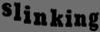

Result: 	 ALEPPO


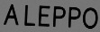

Result: 	 FWANDA


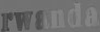

Result: 	 NATHANS


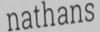

Result: 	 HALLE


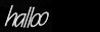

Result: 	 HURLS


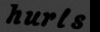

Result: 	 DOWNSIZE


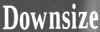

Result: 	 ROBOTIC


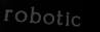

Result: 	 SLOPPY


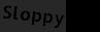

Result: 	 SHERMITE


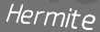

In [132]:
from IPython.display import display
from tensorflow.keras import backend as K
import numpy as np
from PIL import Image

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index < len(chars):  # Ensure index is within bounds
            text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
def check_inference(model, dataset, index=5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1, :, :, :]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-" + TARGET_CHARACTERS)[0].replace('-', '')
        result = result.rstrip('9')  # Trailing '9's are removed
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1, 0, 2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)


In [135]:
import os
import keras_ocr

# 파일 경로 확장
HOME_DIR = os.path.expanduser('~/aiffel/ocr/data')
SAMPLE_IMG_PATH = os.path.join(HOME_DIR, 'sample.jpg')

# SAMPLE_IMG_PATH = os.path.expanduser('~/aiffel/ocr/ocr/data1/MJ/MJ_test/image_00000_Lube.jpg')
# 경로 확인
if not os.path.isfile(SAMPLE_IMG_PATH):
    print(f"Error: File not found at {SAMPLE_IMG_PATH}")
else:
    # 이미지 읽기
    image = keras_ocr.tools.read(SAMPLE_IMG_PATH)
    print("Image successfully loaded.")


Image successfully loaded.


In [137]:
model = build_crnn_model()
model.load_weights(load_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)



In [142]:
from IPython.display import display
from tensorflow.keras import backend as K
import numpy as np
from PIL import Image, ImageDraw
import keras_ocr

# Keras OCR detector 초기화
detector = keras_ocr.detection.Detector()

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
def decode_predict_ctc(out, chars=TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False, beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        if index < len(chars):  # Ensure index is within bounds
            text += chars[index]
    results.append(text)
    return results

# 텍스트 감지 함수 (크롭된 이미지에 빨간 박스 없음)
def detect_text(img_array):
    """
    Keras OCR Detector를 사용하여 텍스트 영역을 감지하고, 원본 이미지는 수정 없이 반환하며
    감지된 텍스트 영역 이미지를 크롭하여 반환합니다.

    Args:
        img_array (numpy.ndarray): 입력 이미지 배열.

    Returns:
        img_pil (PIL.Image): 원본 이미지.
        cropped_imgs (list): 감지된 텍스트 영역 크롭 이미지 리스트.
    """
    img_pil = Image.fromarray(img_array)

    # 텍스트 감지
    ocr_result = detector.detect([img_array])[0]

    cropped_imgs = []
    for text_result in ocr_result:
        # 감지된 텍스트 영역 경계 좌표 계산
        x_min = max(int(text_result[:, 0].min() - 5), 0)
        x_max = min(int(text_result[:, 0].max() + 5), img_array.shape[1])
        y_min = max(int(text_result[:, 1].min() - 5), 0)
        y_max = min(int(text_result[:, 1].max() + 5), img_array.shape[0])

        # 크롭된 텍스트 영역 저장
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs

# 텍스트 인식 함수
def recognize_img(pil_img, input_img_size=(100, 32)):
    """
    잘린 이미지에서 텍스트를 인식합니다.
    """
    try:
        # PIL 이미지를 RGB로 변환
        pil_img = pil_img.convert('RGB')

        # 이미지 전처리
        img_resized = pil_img.resize(input_img_size, Image.ANTIALIAS)
        img_array = np.array(img_resized).astype('float32') / 255.0
        img_array = img_array.transpose(1, 0, 2)  # HWC -> WHC
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

        # 모델 예측
        y_pred = model_pred.predict(img_array)
        print(f"Model Softmax Predictions (sample): {y_pred[0][:10]}")  # 상위 10개 클래스 확률 출력

        # CTC 디코딩
        input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
        decoded = K.get_value(K.ctc_decode(y_pred, input_length=input_length, greedy=True)[0][0])
        print(f"Decoded CTC Output: {decoded}")

        # 디코딩된 결과를 문자로 변환
        recognized_text = ''.join(
            [TARGET_CHARACTERS[i] for i in decoded[0] if i < len(TARGET_CHARACTERS)]
        )
        recognized_text = recognized_text.rstrip('9')  # 불필요한 문자 제거
        return recognized_text
    except Exception as e:
        print(f"Error during recognition: {e}")
        return ""



# End-to-End OCR 실행
def end_to_end_ocr(img_array):
    """
    Trained 모델로 이미지에서 텍스트를 감지하고 인식하는 End-to-End OCR 함수.

    Args:
        img_array (numpy.ndarray): 입력 이미지 배열.

    Returns:
        img_pil (PIL.Image): 원본 이미지.
        recognized_texts (list): 인식된 텍스트 리스트.
        cropped_imgs (list): 감지된 텍스트 크롭 이미지 리스트.
    """
    detected_img, cropped_imgs = detect_text(img_array)

    recognized_texts = []
    for cropped_img in cropped_imgs:
        text = recognize_img(cropped_img)
        recognized_texts.append(text)

    return detected_img, recognized_texts, cropped_imgs



Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


Model Softmax Predictions (sample): [[1.38257127e-02 8.30615032e-03 4.61255247e-03 1.06552681e-02
  2.63107941e-03 5.31423278e-03 8.17237049e-03 3.77849233e-03
  2.01756763e-03 6.84429193e-03 1.21966228e-02 3.29406495e-04
  1.90284301e-03 3.20349447e-03 4.13354579e-03 1.73573028e-02
  2.76323147e-02 2.28759889e-02 4.70597856e-03 8.89421348e-03
  5.61912311e-03 2.28002574e-03 1.91076528e-02 3.61554627e-03
  1.38945517e-03 2.43749190e-03 1.04826328e-03 2.13091332e-03
  1.87401474e-03 1.42636208e-03 8.72425851e-04 7.73891632e-04
  6.26323395e-04 6.06167479e-04 3.12276679e-04 8.75747413e-04
  7.41112337e-04 7.84873784e-01]
 [1.01983850e-03 5.36032813e-03 3.20812035e-03 1.46219283e-02
  1.69868243e-03 6.58472627e-03 7.53205502e-03 4.35689185e-03
  1.35250844e-03 3.81871476e-03 6.79789158e-03 8.49373173e-05
  1.10677176e-03 8.34613456e-04 2.35360349e-03 1.95008833e-02
  3.79523933e-02 1.84305403e-02 5.12506813e-03 5.99269476e-03
  4.99510020e-03 1.40445272e-03 2.34622248e-02 1.57274678e-03
 

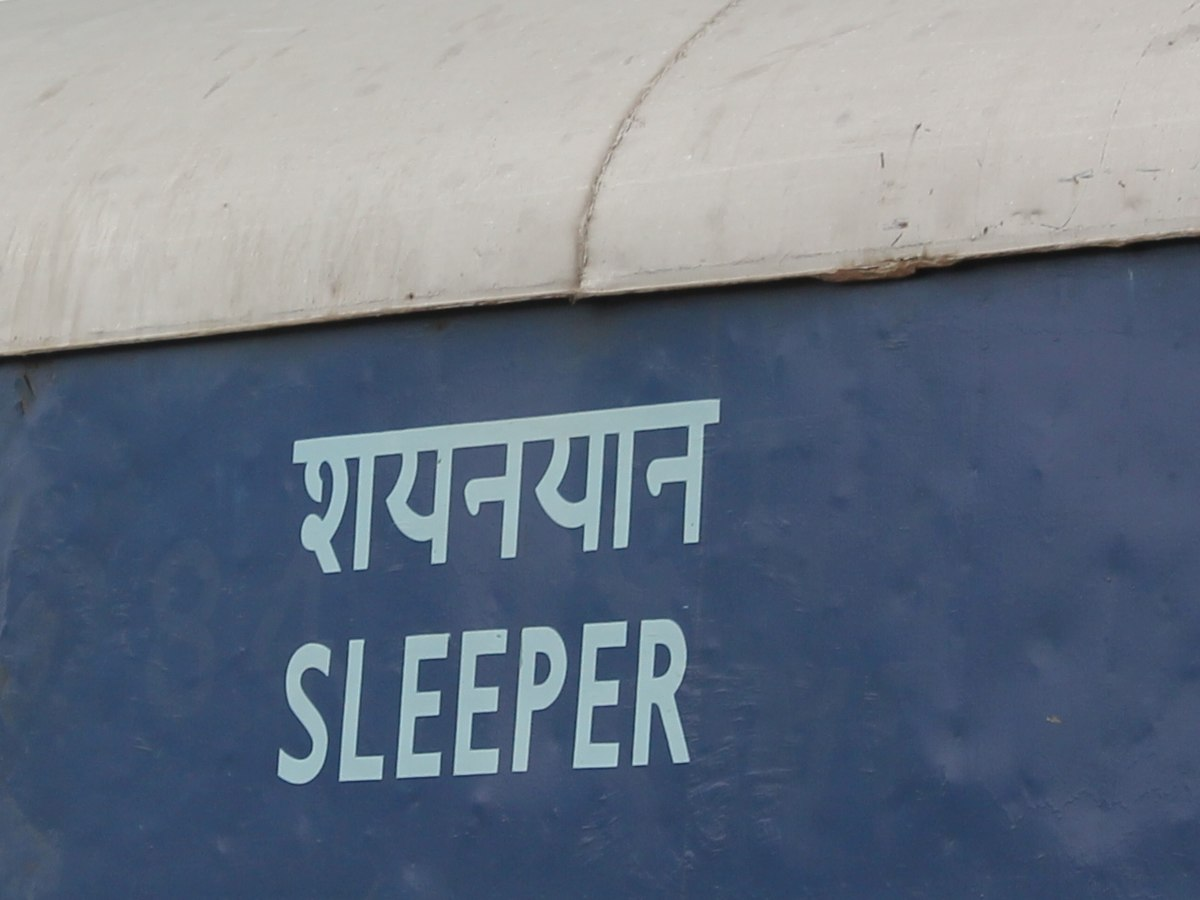

인식된 텍스트:
텍스트 1: FZ
텍스트 2: FZ
크롭된 텍스트 영역 이미지:
크롭 이미지 1:


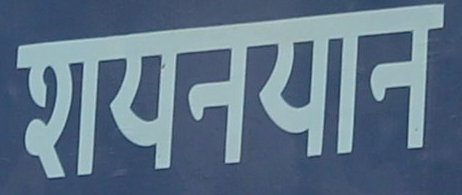

크롭 이미지 2:


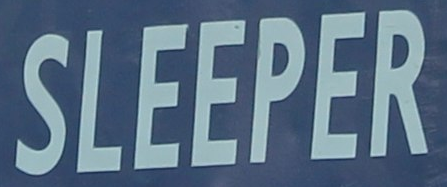

In [143]:
# 샘플 이미지 실행
image_array = keras_ocr.tools.read(SAMPLE_IMG_PATH)  # 이미지를 numpy.ndarray로 읽기
result_img, recognized_texts, cropped_imgs = end_to_end_ocr(image_array)

# 결과 출력
print("원본 이미지:")
display(result_img)

print("인식된 텍스트:")
for idx, text in enumerate(recognized_texts):
    print(f"텍스트 {idx + 1}: {text}")

print("크롭된 텍스트 영역 이미지:")
for idx, cropped_img in enumerate(cropped_imgs):
    print(f"크롭 이미지 {idx + 1}:")
    display(cropped_img)


Image successfully loaded.
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
원본 이미지:


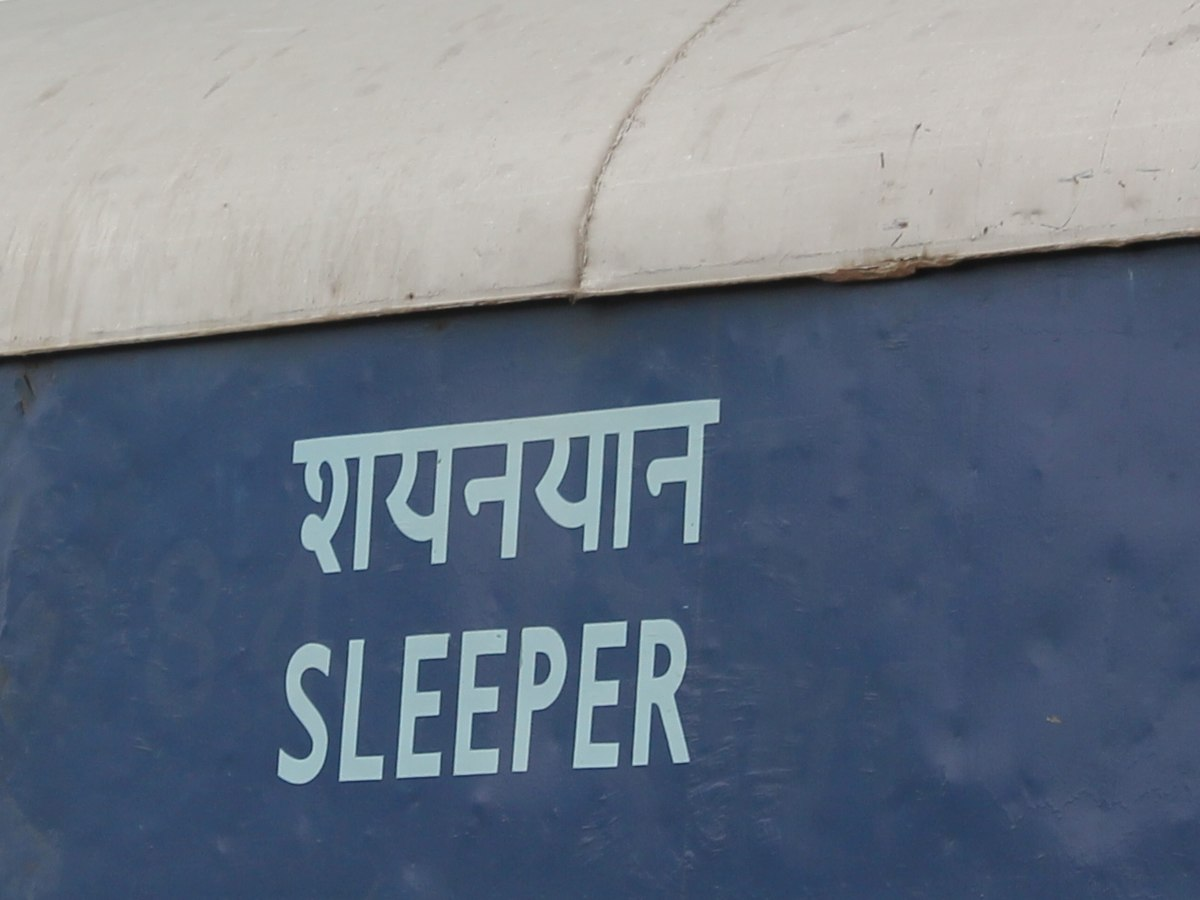

인식된 텍스트:
텍스트 1: FZ
텍스트 2: FZ
크롭된 텍스트 영역 이미지:
크롭 이미지 1:


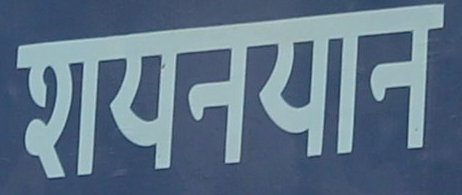

크롭 이미지 2:


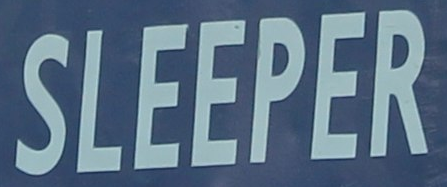

In [174]:
import os
import keras_ocr
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np
from PIL import Image, ImageDraw
from IPython.display import display

# 파일 경로 확장
HOME_DIR = os.path.expanduser('~/aiffel/ocr/data')
SAMPLE_IMG_PATH = os.path.join(HOME_DIR, 'sample.jpg')

# 경로 확인
if not os.path.isfile(SAMPLE_IMG_PATH):
    print(f"Error: File not found at {SAMPLE_IMG_PATH}")
else:
    # 이미지 읽기
    image = keras_ocr.tools.read(SAMPLE_IMG_PATH)
    print("Image successfully loaded.")


# Keras OCR detector 초기화
detector = keras_ocr.detection.Detector()

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
def decode_predict_ctc(out, chars):
    results = []
    decoded = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=True
        )[0][0]
    )
    for seq in decoded:
        text = ''.join([chars[i] for i in seq if i >= 0 and i < len(chars)])
        results.append(text)
    return results

# 텍스트 감지 함수 (크롭된 이미지에 빨간 박스 없음)
def detect_text(img_array):
    """
    Keras OCR Detector를 사용하여 텍스트 영역을 감지하고, 원본 이미지는 수정 없이 반환하며
    감지된 텍스트 영역 이미지를 크롭하여 반환합니다.

    Args:
        img_array (numpy.ndarray): 입력 이미지 배열.

    Returns:
        img_pil (PIL.Image): 원본 이미지.
        cropped_imgs (list): 감지된 텍스트 영역 크롭 이미지 리스트.
    """
    img_pil = Image.fromarray(img_array)

    # 텍스트 감지
    ocr_result = detector.detect([img_array])[0]

    cropped_imgs = []
    for text_result in ocr_result:
        # 감지된 텍스트 영역 경계 좌표 계산
        x_min = max(int(text_result[:, 0].min() - 5), 0)
        x_max = min(int(text_result[:, 0].max() + 5), img_array.shape[1])
        y_min = max(int(text_result[:, 1].min() - 5), 0)
        y_max = min(int(text_result[:, 1].max() + 5), img_array.shape[0])

        # 크롭된 텍스트 영역 저장
        word_box = [x_min, y_min, x_max, y_max]
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs

# 텍스트 인식 함수
def recognize_img(pil_img, input_img_size=(100, 32)):
    """
    잘린 이미지에서 텍스트를 인식합니다.
    """
    try:
        # PIL 이미지를 RGB로 변환
        pil_img = pil_img.convert('RGB')

        # 이미지 전처리
        img_resized = pil_img.resize(input_img_size, Image.ANTIALIAS)
        img_array = np.array(img_resized).astype('float32') / 255.0
        img_array = img_array.transpose(1, 0, 2)  # HWC -> WHC
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

        # 모델 예측
        y_pred = model_pred.predict(img_array)
    

        # CTC 디코딩
        input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
        recognized_texts = decode_predict_ctc(y_pred, TARGET_CHARACTERS)
        recognized_text = recognized_texts[0] if recognized_texts else ""

        return recognized_text.rstrip('9')  # 불필요한 문자 제거
    except Exception as e:
        print(f"Error during recognition: {e}")
        return ""

# End-to-End OCR 실행
def end_to_end_ocr(img_array):
    """
    Trained 모델로 이미지에서 텍스트를 감지하고 인식하는 End-to-End OCR 함수.

    Args:
        img_array (numpy.ndarray): 입력 이미지 배열.

    Returns:
        img_pil (PIL.Image): 원본 이미지.
        recognized_texts (list): 인식된 텍스트 리스트.
        cropped_imgs (list): 감지된 텍스트 크롭 이미지 리스트.
    """
    detected_img, cropped_imgs = detect_text(img_array)

    recognized_texts = []
    for cropped_img in cropped_imgs:
        text = recognize_img(cropped_img)
        recognized_texts.append(text)

    return detected_img, recognized_texts, cropped_imgs

# 샘플 이미지 실행
image_array = keras_ocr.tools.read(SAMPLE_IMG_PATH)  # 이미지를 numpy.ndarray로 읽기
result_img, recognized_texts, cropped_imgs = end_to_end_ocr(image_array)

# 결과 출력
print("원본 이미지:")
display(result_img)

print("인식된 텍스트:")
for idx, text in enumerate(recognized_texts):
    print(f"텍스트 {idx + 1}: {text}")

print("크롭된 텍스트 영역 이미지:")
for idx, cropped_img in enumerate(cropped_imgs):
    print(f"크롭 이미지 {idx + 1}:")
    display(cropped_img)


In [165]:
model = build_crnn_model()
model.load_weights(load_path)

# CRNN 모델 재구성 (inference 전용)
input_image = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_image, outputs=y_pred)


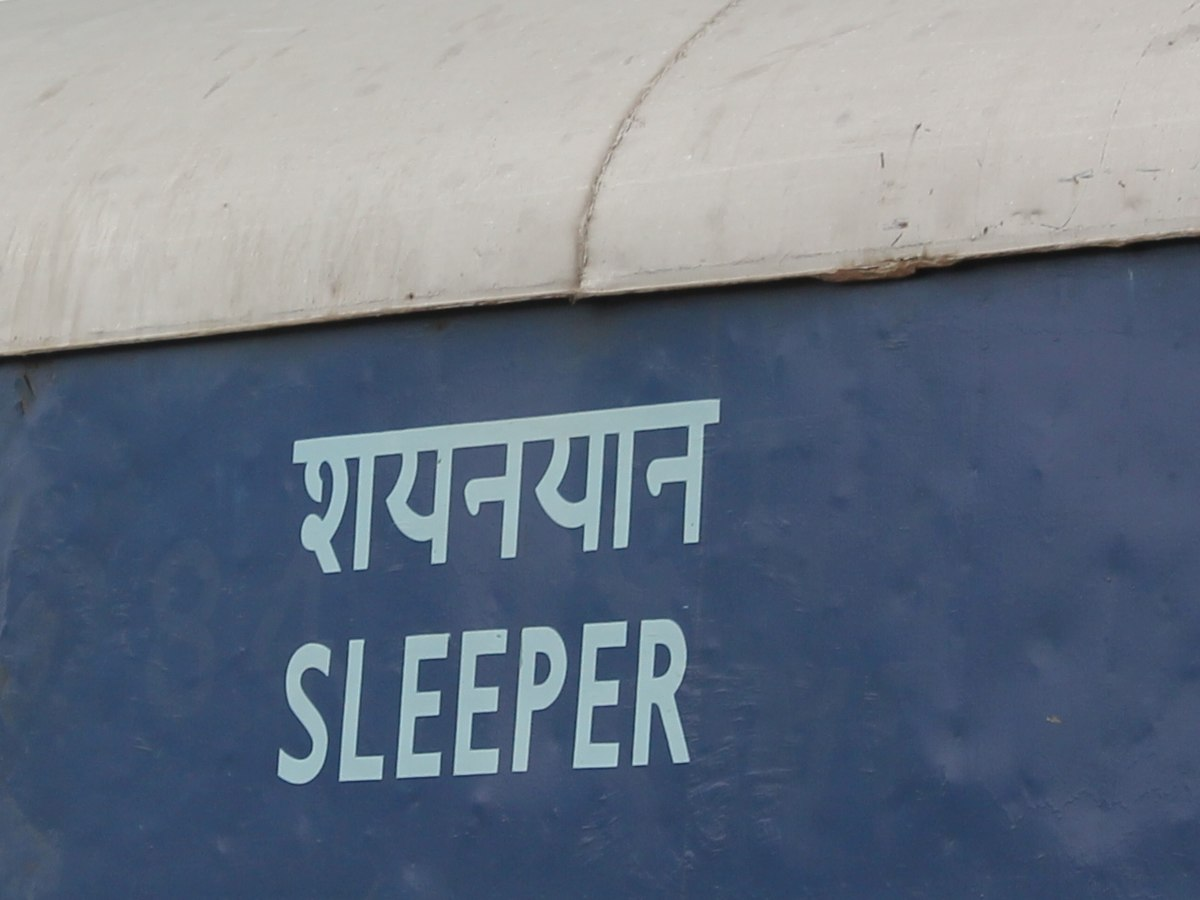

In [157]:
image_array = keras_ocr.tools.read(SAMPLE_IMG_PATH)  # 이미지를 numpy.ndarray로 읽기
img_pil, cropped_img = detect_text(image_array)
display(img_pil)

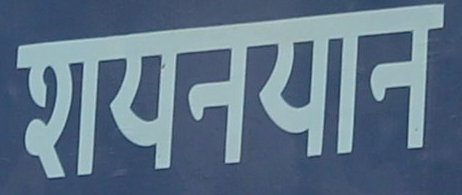

Cropped Image 1 Size: (462, 195)


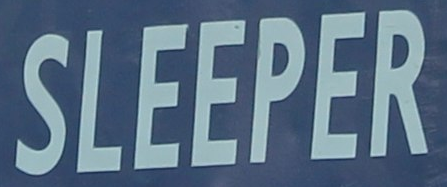

Cropped Image 2 Size: (447, 187)


In [158]:
# 크롭된 텍스트 이미지 확인
for i, img in enumerate(cropped_img):
    # cropped_img.show(title=f"Cropped Image {i+1}")
    display(img)
    print(f"Cropped Image {i+1} Size: {img.size}")  # 이미지 크기 출력

In [161]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    """
    잘린 이미지에서 텍스트를 인식합니다.
    """
    try:
        # PIL 이미지를 RGB로 변환
        pil_img = pil_img.convert('RGB')

        # 이미지 전처리
        img_resized = pil_img.resize(input_img_size, Image.ANTIALIAS)
        img_array = np.array(img_resized).astype('float32') / 255.0
        img_array = img_array.transpose(1, 0, 2)  # HWC -> WHC
        img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

        # 모델 예측
        y_pred = model_pred.predict(img_array)
       

        # CTC 디코딩
        input_length = np.ones(y_pred.shape[0]) * y_pred.shape[1]
        recognized_texts = decode_predict_ctc(y_pred, TARGET_CHARACTERS)
        recognized_text = recognized_texts[0] if recognized_texts else ""

        return recognized_text.rstrip('9')  # 불필요한 문자 제거
    except Exception as e:
        print(f"Error during recognition: {e}")
        return ""


In [166]:
def recognize_img(pil_img, input_img_size=(100,32)):
    # 모델 예측
    output = model_pred.predict(np.expand_dims(np.array(pil_img.resize((100, 32), 3)).transpose(1, 0, 2), axis=0))
    
    # CTC 디코딩 결과 가져오기
    result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
    print("Result: \t", result)
    display(Image.fromarray(np.array(pil_img.resize((100, 32), 3)).astype(np.uint8)))
    

Result: 	 S


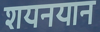

Result: 	 S


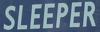

In [167]:
for _img in cropped_img:
    recognize_img(_img)

회고
- keras_ocr을 이용하여 글자를 티텍팅하고 인식하였다.
- 글자 인식하고 평가를 진행하였다.
- 범위를 인식하여 그분만 추출하고 인식을 진행하였다.
- 학습가중치가 잘 적용되지 않아아 글자 인식의 선능이 좋지 않았다.
- 추후 추가 학습을 적용하여 보완이 필요할 것 같다.

